In [1]:
#  MODIFICATION HISTORY:
# Written in Python by Juan Pablo Velásquez (January 1st, 2021) 
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import matplotlib.dates as mdates
import h5py
from datetime import timedelta
import os
from model_utils import *
#set_nb_theme('chesterish')
import matplotlib.dates as mdates

In [2]:
h_min = 250
h_max= 500
def getRangeIndices(h_min, h_max, range_array):
    min_ind = list(np.abs(h_min-range_array)).index(min(np.abs(h_min-range_array)))
    max_ind = list(np.abs(h_max-range_array)).index(min(np.abs(h_max-range_array)))
    #print(min_ind, max_ind)
    #print(range_array[min_ind], range_array[max_ind])
    return min_ind, max_ind

In [3]:
def getF107(month,year):
    dir_path = "geomagnetic_indices"
    filename = "hourly-geomagnetic-indices-%02d-%d.txt" % (month, year)
    filename = './' + dir_path + '/' + filename
    #current_month = 'Noviembre-2020'
    meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
    current_month = '%s-%d' % (meses[month-1], year)
    dir_plots = 'Plots-%s/' % current_month
    Data = pd.read_csv(filename,delimiter=r"\s+")#
    indices = GetIndices(Data)
    Data.set_index(indices)
    
    return Data

In [4]:
def getIndexF107(year, doy, hour):
    d = datetime.datetime.strptime('{} {}'.format(doy, year),'%j %Y')
    month = d.month
    F107 = getF107(month,year)
    #F107.tail()
    a = F107.loc[(F107['Hour'] == hour) & (F107['DayOfYear'] == doy), 'F107']
    #a.apply(lambda x: float(x))
    #print(a)
    return float(a)

In [5]:
'''
;  PURPOSE:
;    The VDRIFT_MODEL procedure is the main routine for obtaining vertical drifts. The vertical drifts
;    dependences of the local time and longitudinal (See details in Scherlies and Fejer, 1999). 
;  INPUTS:
;    DOY = A scalar of integer type giving the Day of year. (e.g. doy = 347)
;    HOUR = Set this keyword to an integer  from 00 to 23 to define the hour (00... 24hrs). By default 
;      hour =12.
;    F107CM = A scalar giving the solar flux F10.7cm. By default it will take 150.
;    LONGITUDE = Geographic Longitude.    
;  OUTPUTS:
;    vdrift= vertical drifts
'''

def drift_model(year, doy,longitude):
    if doy == 0:
        doy = 161
    if longitude ==0:
        longitude = 270.0
    #constant = longitude
    start = 0.0
    finish = 23.5
    step = 0.5
    #nsteps = 49
    #step = int(finish-start)/nsteps
    ###############################################################
    #st = 0.0
    end = 23.5
    nsteps = 49
    a = np.linspace(start,end,nsteps, endpoint=False)
    minutos = []
    horas = []
    for t in a:
        hour, minute = divmod(t, 1)
        minute *= 60
        result = '{}:{}'.format(int(hour), int(minute))
        #print(result)
        horas.append(int(hour))
        minutos.append(int(minute))
    ###################
    #year = 2020
    d = datetime.datetime.strptime('{} {}'.format(doy, year),'%j %Y')
    ###################
    m = np.zeros(nsteps)
    steps = np.zeros(nsteps)
    #FOR i=start,(finish*(1+(profil EQ 0))) DO steps[i]=i*step
    j=0
    f107_list = []#getIndexF107(year, doy, hour)
    datetime_list = []
    for i in np.linspace(start,finish,nsteps,endpoint=False):
        steps[j]=i*step
        temp = i#start + i*step
        steps[j] = temp
        str_time = '%d-%02d-%02d %02d:%02d:%02d' % (year, d.month, d.day,horas[j], minutos[j],0)
        dt = datetime.datetime.strptime(str_time, '%Y-%m-%d %H:%M:%S')
        datetime_list.append(dt)
        #print('i:', int(i))
        f107_list.append(getIndexF107(year, doy, int(i)))
        j = j + 1
    time = steps
    yv = []
    #Calling VDrifts to compute vertical drifts.
    for ii in range(0,(nsteps-1) + 1):
        xt=time[ii]
        xl=longitude
        y=vdrift(xt,xl,doy,f107_list[ii])
        yv.append(y)
    return yv,datetime_list

### Comparison:

In [6]:
import datetime
#format = "%Y-%m-%d %H:%M:%S"
year=2021
month = 3
longitude=-76.7

doys = []
days = []

if year==2020:
    if month==11:
        doys=[329,330,331,332]
        days=[24,25,26,27]
    if month==12:
        days=[10,11,12,13,14,15,16]
        doys=[345,346,347,348,349,350,351]
if year==2021:
    if month==1:
        doys = [20,21,22,23]#[3,4,5,6,7,8,9,10,11,20,21,22,23]
        days = [20,21,22,23]#[3,4,5,6,7,8,9,10,11,20,21,22,23]#[24,25,26,27]#,16
    if month==3:
        doys=[81,82,83,84]
        days=[22,23,24,25]
doy = doys[0]
d = datetime.datetime.strptime('{} {}'.format(doy, year),'%j %Y')
print(d)

2021-03-22 00:00:00


In [7]:
PlotFlag =  True
plot_format = 'png'
str_month = GetMonth(month)
current_month = '%s-%d' % (str_month, year)
directory = 'Data-%s/regular-files/' % current_month
str_format = 'png'
filename = 'jro%d%02d%02ddrifts.001.hdf5' % (year, d.month, d.day)
dir_plots = 'Plots-%s' % current_month

In [8]:
file_hf5 = directory + filename
hf = h5py.File(file_hf5, 'r')
#with h5py.File(file_hf5, 'r') as f:
#    g = f.visit(print)


In [9]:
def GetMatrix(directory, filename, PlotFlag, plot_format):
    ##########################################################
    ## 2020-06-16: Se verificó que la función trabaja
    ## correctamente. Se creara una nueva para hacer pruebas 
    ## con las dimensiones
    ##########################################################
    file_hf5 = directory + filename
    hf = h5py.File(file_hf5, 'r')
    #with h5py.File(file_hf5, 'r') as f:
    #    g = f.visit(print)
    '''
    days = np.array(hf['Data/Table Layout/']['day'],dtype=int)
    year = np.array(hf['Data/Table Layout/']['year'],dtype=int)
    month = np.array(hf['Data/Table Layout/']['month'],dtype=int)
    hour = np.array(hf['Data/Table Layout/']['hour'],dtype=int)
    minutes = np.array( hf['Data/Table Layout/']['min'],dtype=int)
    seconds = np.array(hf['Data/Table Layout/']['sec'],dtype=int)
    '''
    rango = hf['Data/Table Layout/']['gdalt']
    #rango2D = hf['Data/Array Layout/']['range']
    #Data/Array Layout/timestamps
    timestamps = hf['Data/Array Layout/']['timestamps']
    #snl =  hf['Data/Table Layout/']['snl']
    #snl2 = hf['Data/Array Layout/2D Parameters/snl']
      
    vipe1 = hf['Data/Array Layout/2D Parameters/vipe1'] 
    vipn1 = hf['Data/Array Layout/2D Parameters/vipn2']
    v_zonal = np.array(vipe1)
    v_vertical = np.array(vipn1)
    #snl2 = np.array(snl2)
    time_vector = []
    date_list = [] # list for datetime objects
  
    rango = getattr(rango, "tolist", lambda: rango)()
    ###########################################################
    ran_max = max(rango)
    ran_min = min(rango)
    #rang_list = list(rango)
    max_index = rango.index(ran_max)
    min_index = rango.index(ran_min)
    range_diff = np.diff(rango)
    delta_range = range_diff[0] #valor constante para todo el arreglo
    MinRange, MaxRange = np.min(rango), ran_max#np.max(rango)
    DataMatrixRows = int((MaxRange-MinRange)/delta_range) + 1
    #DataMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    #RowInMatrix = np.array((rango-MinRange)/delta_range+1, dtype=int)
    range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
    #RangeMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    #DataMatrix_v_zonal = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    #DataMatrix_v_vertical = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    
    #string_date = timestamps[0]#.strftime('%B %d, %Y, %r')
    #date_time_str = '2018-06-29 08:15:27.243860'
    
    datetime_objects = []
    for ts in timestamps:
        date_time_obj = datetime.datetime.fromtimestamp(ts)
        datetime_objects.append(date_time_obj)
    index = pd.DatetimeIndex(datetime_objects) #- timedelta(hours=5)

    #line.split()[0]
    #mes = #string_date.split()[0]
    mes = date_time_obj.month
    print(mes)
    #month_prime = 11
    month_str = GetMonth(mes)
    dia = date_time_obj.day
    anio = date_time_obj.year
    
    dir_plots = 'Plots-%s-%d' % (month_str, anio)
    print(dir_plots)
    #######################################################################################################
    if (PlotFlag):
        fig, ax = plt.subplots(figsize=(12, 6))
        #plt.rcParams['xtick.labelsize']=14
        
        #plt.style.use('dark_background')
        x_min = mdates.date2num(np.min(index))
        x_max = mdates.date2num(np.max(index))
        #extent=[x_min, x_max,ran_min,ran_max]
        print("Shapes: ", v_vertical.T.shape, range_array.shape, len(datetime_objects))
        #ax = plt.imshow(v_vertical.T, cmap='jet',aspect='auto',interpolation='nearest',origin="lower", extent=extent)
        clrs= ax.pcolormesh(mdates.date2num(datetime_objects), range_array, v_vertical.T, cmap='jet')
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        fig_title = r'Derivas Verticales ISR (%d-%02d-%02d)' % (anio, mes, dia) 
        plt.title(fig_title, fontsize=15)
        str_date = '(%d-%02d-%02d)' % (anio, mes, dia)
        #ax.set_ylim(300, 400)
        string_t0 = '%d-%02d-%02d %02d:00:00' % (year, index[0].month, index[0].day, 0)
        string_tf = '%d-%02d-%02d %02d:00:00' % (year, index[0].month, index[0].day+1, 0)
        dt0 = datetime.datetime.strptime(string_t0, '%Y-%m-%d %H:%M:%S')
        dtf = datetime.datetime.strptime(string_tf, '%Y-%m-%d %H:%M:%S')
        ax.set_xlim(mdates.date2num(dt0),mdates.date2num(dtf))
        
        # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        box=ax.get_position()
        cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
        cb=plt.colorbar(clrs,cax=cbarax)
        #cb.set_label(r'Derivas verticales (m/s)')
        #cb2 = fig.colorbar(im2)
       # cb2.set_label(r'$lo      '''y,xt
       
        plt.rcParams['xtick.labelsize']=14
      
        plt.savefig(r'%s/v-vertical-isr-%d-%02d-%02d.%s' % (dir_plots,year, mes, dia, plot_format))
        #plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-SNR.png' % (dir_plots,anio, month_prime, dia))
        plt.show()
        plt.close(fig)   
        
    #####################################################################################
  
    return index, range_array, rango, dir_plots, v_zonal, v_vertical, timestamps, str_date

3
Plots-Marzo-2021
Shapes:  (100, 182) (100,) 182


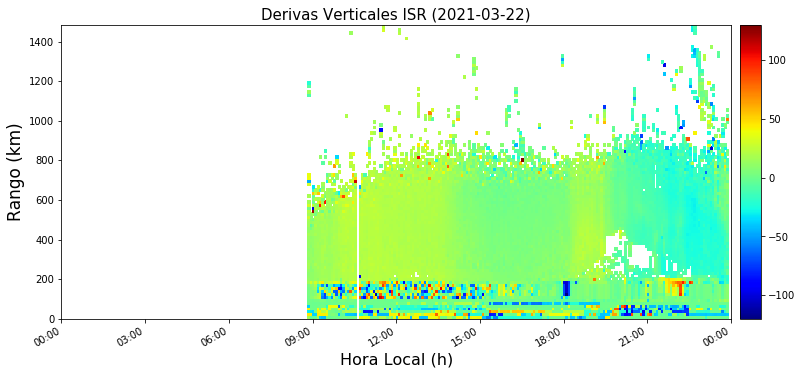

(2021-03-22)
Vertical Average shape:  (182,) (182,) 2021-03-22 08:50:00 2021-03-22 23:55:00


/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/juanpablo/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


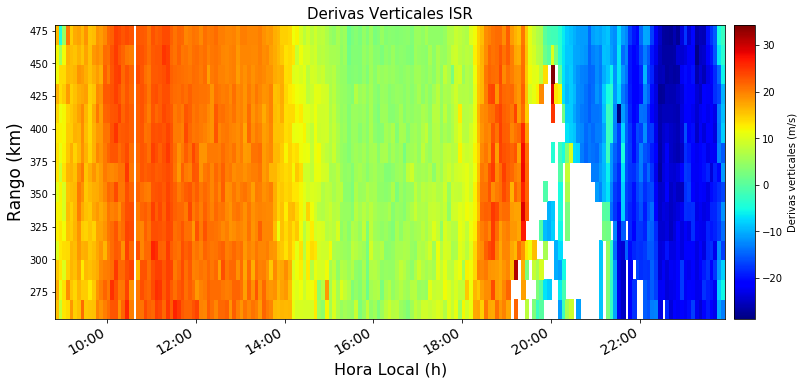

In [10]:
#index, range_array, rango, dir_plots, v_zonal, v_vertical, timestamps, str_date = GetMatrix(directory, filename, PlotFlag, plot_format)
str_format = 'png'
index, range_array, rango, dir_plots, v_zonal, v_vertical, timestamps, str_date = GetMatrix(directory, filename, PlotFlag, plot_format)
#print(index)
#h_min, h_max = 300, 400
min_ind, max_ind = getRangeIndices(h_min, h_max, range_array)
#print("Data, index, range_array y len(rango): ")
#print(data.shape, index.shape, range_array.shape, len(rango))
#str_date = '%d-%02d-%02d' % (index[0].year,index[0].month,index[0].day)
print(str_date)
prev_times = [' ']
prev_stamps = [' ']

#print(time_vector)
k = 0
#################################
datetime_objects = []
for ts in timestamps:
    if ts in prev_stamps:
        print('Same timestap')
    else:
        date_time_obj = datetime.datetime.fromtimestamp(ts)
        datetime_objects.append(date_time_obj)
new_index = pd.DatetimeIndex(datetime_objects) # timedelta(hours=5)
#################################

#'''
data = v_vertical[:,min_ind:max_ind]

#fig, ax = plt.subplots(figsize=(12, 6))       
v_vert_avg = np.nanmean(data,axis=1)
v_vert_std = np.nanstd(data,axis=1)
print("Vertical Average shape: ", v_vert_avg.shape, new_index.shape, new_index[0], new_index[-1])

#print(range_array)
#'''
fig, ax = plt.subplots(figsize=(12, 6))
#plt.imshow(v_vertical.T[min_ind:max_ind,:])
clrs= ax.pcolormesh(mdates.date2num(datetime_objects), range_array[min_ind:max_ind], data.T, cmap='jet')
ax.xaxis_date()
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel("Hora Local (h)", fontsize=16)
ax.set_ylabel("Rango (km)", fontsize=17)
fig_title = r'Derivas Verticales ISR' #(%d-%02d-%02d)' #% (anio, month_prime, dia) 
plt.title(fig_title, fontsize=15)
#str_date = '(%d-%02d-%02d)' % (anio, month_prime, dia)
#ax.set_ylim(0, 200)
# This simply sets the x-axis data to diagonal so it fits better.
fig.autofmt_xdate()
box=ax.get_position()
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)
cb.set_label(r'Derivas verticales (m/s)')
#'''

In [11]:
#v_vert_avg = np.nanmean(v_vertical,axis=1)
#v_vert_std = np.nanstd(v_vertical,axis=1)

df = pd.Series(v_vert_avg, index=index)
df_std = pd.Series(v_vert_std, index=index)

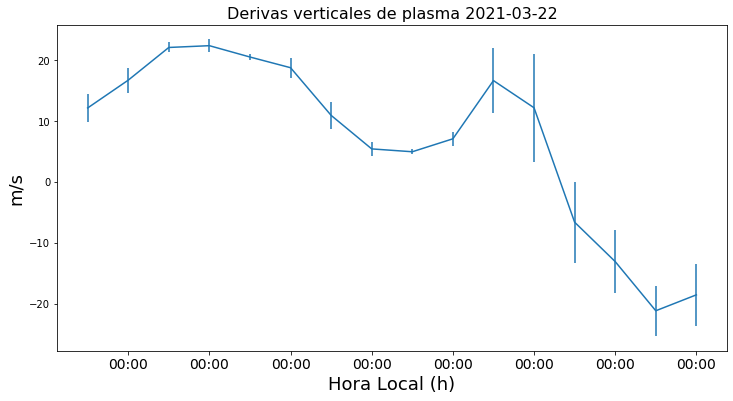

In [12]:
#'''
fig, axs = plt.subplots(figsize=(12, 6))

df.groupby(df.index.hour).mean().plot(yerr=df.groupby(df_std.index.hour).std(),rot=0,ax=axs)
fig_title = 'Derivas verticales de plasma %d-%02d-%02d' % (index[0].year,index[0].month, index[0].day)
axs.set_title(fig_title, fontsize=16)
#axs.set_facecolor("white")
date_format = mdates.DateFormatter('%H:%M')
#axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axs.set_xlabel('Hora Local (h)', fontsize=18)
axs.set_ylabel('m/s', fontsize=18)
#axs.set_xlim([100,400])
axs.xaxis_date()
axs.xaxis.set_major_formatter(date_format)
#plt.savefig('promedio-mensual-drifts-agosto-2020.pdf')
#'''
#plt.plot(dt_index, df.groupby(index,df.index.hour).mean())


### Promedio mensual:

jro20210325drifts.001.hdf5
3
Plots-Marzo-2021
Shapes:  (100, 226) (100,) 226


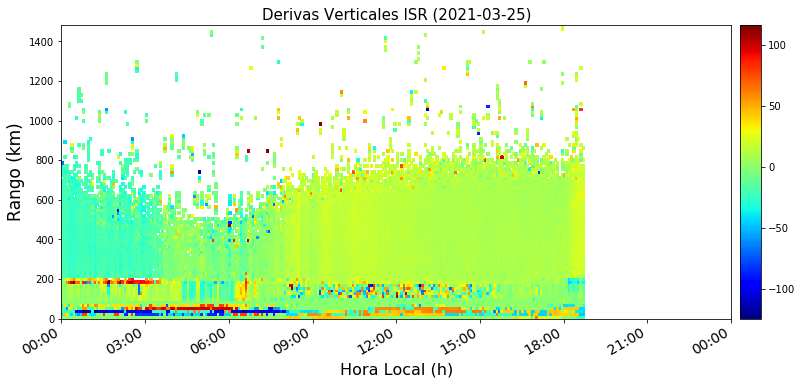

Data, index, range_array y len(rango): 
(2021-03-25)
226 (226, 100)
(226,) (226,)
2021-03-25 00:00:00 2021-03-26 00:00:00
jro20210323drifts.001.hdf5
3
Plots-Marzo-2021
Shapes:  (100, 288) (100,) 288


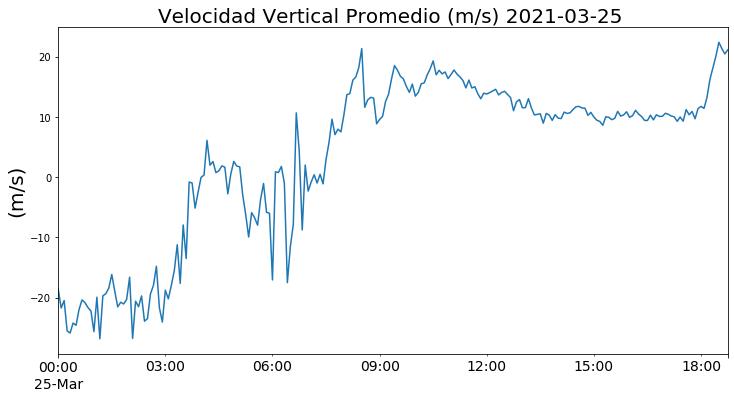

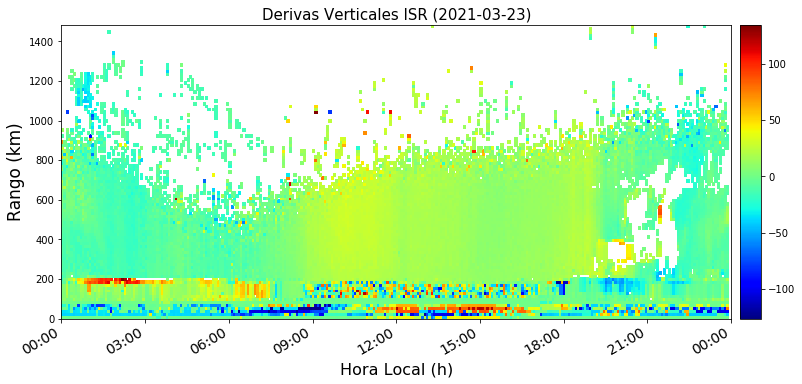

Data, index, range_array y len(rango): 
(2021-03-23)
288 (288, 100)
(288,) (288,)
2021-03-23 00:00:00 2021-03-24 00:00:00
jro20210322drifts.001.hdf5
3
Plots-Marzo-2021
Shapes:  (100, 182) (100,) 182


/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice
/home/juanpablo/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


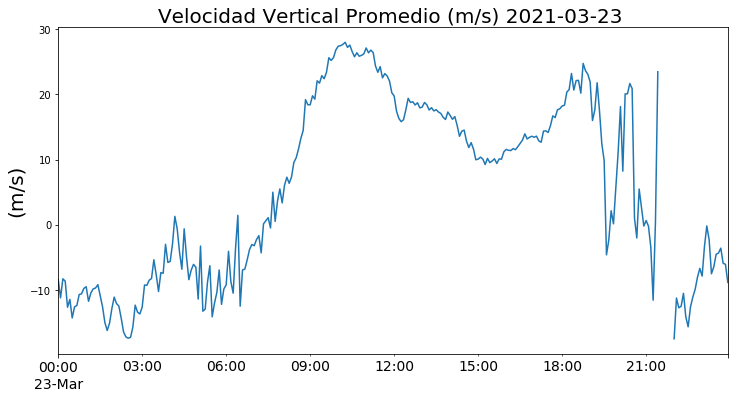

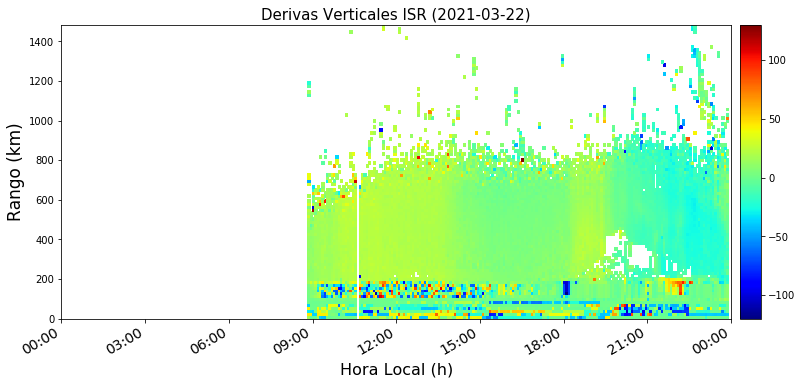

Data, index, range_array y len(rango): 
(2021-03-22)
182 (182, 100)
(182,) (182,)
2021-03-22 00:00:00 2021-03-23 00:00:00
jro20210324drifts.001.hdf5


/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice
/home/juanpablo/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


3
Plots-Marzo-2021
Shapes:  (100, 288) (100,) 288


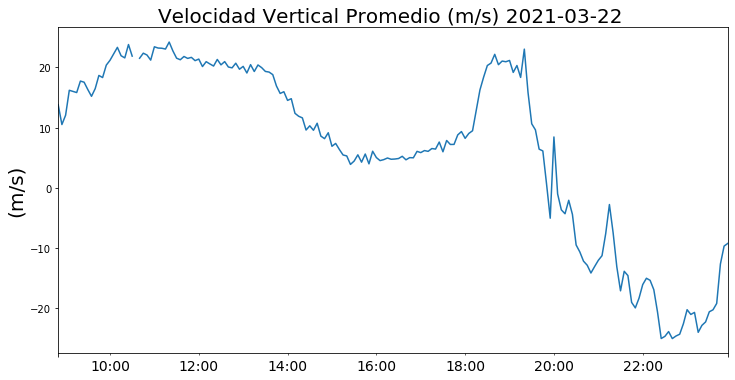

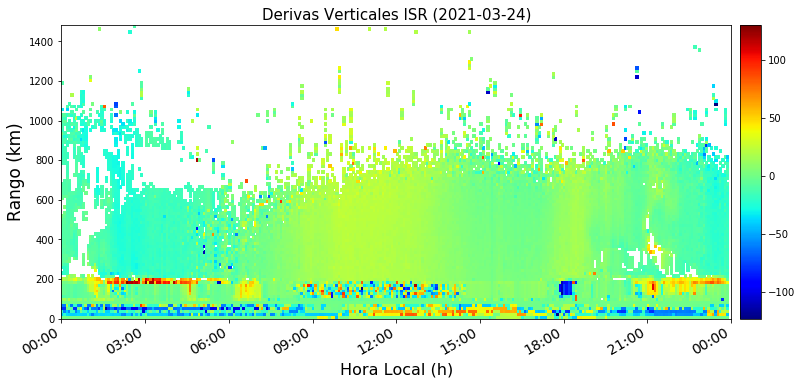

Data, index, range_array y len(rango): 
(2021-03-24)
288 (288, 100)
(288,) (288,)
2021-03-24 00:00:00 2021-03-25 00:00:00


/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice
/home/juanpablo/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


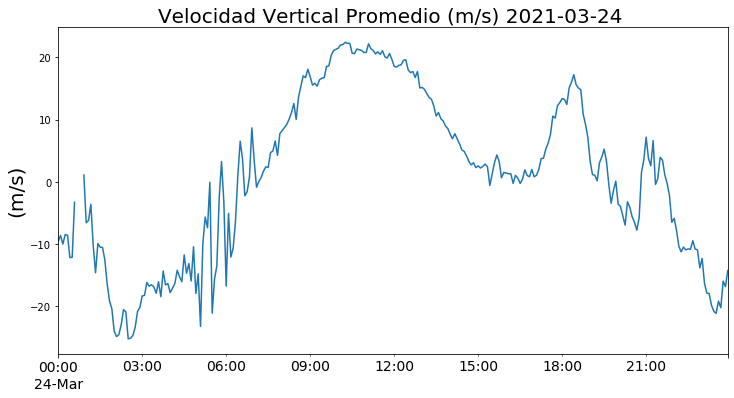

In [13]:
PlotFlag = True
plot_format= 'png'
h_min = []
h_max = []
frames_avg = []
frames_std = []
num_stamps = [] 
t_h_min = []
t_h_max = []
#year = 2020
#i = 0
for filename2 in os.listdir(directory):
    if filename2.endswith(".hdf5"):
        print(filename2)
        
        index, range_array, rango, dir_plots, v_zonal, v_vertical, timestamps, str_date = GetMatrix(directory, filename2, PlotFlag, plot_format)
        print("Data, index, range_array y len(rango): ")
        #print(data.shape, index.shape, range_array.shape, len(rango))
        #str_date = '%d-%02d-%02d' % (index[0].year,index[0].month,index[0].day)
        
        print(str_date)
        prev_times = [' ']
        k = 0
        for time in index:
            if prev_times[k] == time:
                   print('Same Time')
            else:
                #print 'Different time'
                if not time in prev_times:
                    prev_times.append(time)
                prev_time = time
        
 
    ###########################################################
        ran_max = max(rango)
        ran_min = min(rango)
        max_index = rango.index(ran_max)
        min_index = rango.index(ran_min)
    ############################################################
        #num_stamps.append(len(timestamps))
        prev_times = prev_times[1:]
        num_diff_times = len(prev_times)
        print(num_diff_times, v_vertical.shape)
       
        new_index = pd.DatetimeIndex(prev_times)
        #print("Vertical Average shape: ", v_vert_avg.shape, new_index.shape, new_index[0], new_index[-1])
        #fig, ax = plt.subplots(figsize=(12, 6))
        h_min, h_max = 250, 500
        min_ind, max_ind = getRangeIndices(h_min, h_max, range_array)
        str_format = 'png'
        v_vert_avg = np.nanmean(v_vertical[:,min_ind:max_ind],axis=1)
        v_vert_std = np.nanstd(v_vertical[:,min_ind:max_ind],axis=1)
        #d = datetime.datetime.strptime('{} {}'.format(doy, year),'%j %Y')
        #y,xt = drift_model(year,doys[i],longitude)
        #df_v = pd.Series(y, index=xt)
        df_std = pd.Series(v_vert_std, index=new_index)
        print(v_vert_avg.shape, index.shape)
        df = pd.Series(v_vert_avg, index=new_index)
        #df.set_index(new_index, inplace=True, drop=True)
        str_date = '%d-%02d-%02d ' % (year, index[0].month, index[0].day)
        #Cambiar de acuerdo al mes (diferentes tiempos de medición)
        #Enero-2021: mismo día, de 8 a 19
        string_t0 = '%d-%02d-%02d %02d:00:00' % (year, index[0].month, index[0].day, 0)
        string_tf = '%d-%02d-%02d %02d:00:00' % (year, index[0].month, index[0].day+1, 0)
        #'''
        fig1, ax = plt.subplots(figsize=(12, 6))
        print(string_t0,string_tf)
        df.loc[string_t0:string_tf].plot()
        #df_v.loc[string_t0:string_tf].plot()
        ax.xaxis_date()
        ax.set_ylabel('(m/s)', fontsize=20)
        ax.set_title('Velocidad Vertical Promedio (m/s) %s' % str_date, fontsize=20)
        #ax.xaxis.set_major_formatter(mdates.DateFormatter('%H %M'))
        #'''
        #i = i + 1
        plt.savefig('%s/velocidad-vertical-promedio-%s.%s' % (dir_plots,str_date, str_format))
        #plt.show()
        #plt.close(fig)
        #print("Range array shape: ", np.array(rango).shape)
        
        #str_date = '%d-%02d-%02d' % (new_index[0].year,new_index[0].month,new_index[0].day)
        #str_format = 'png'
        #v_vert_avg = np.nanmean(v_vertical,axis=1)
        #v_vert_std = np.nanstd(v_vertical,axis=1)
        #'''
        #df_std = pd.Series(v_vert_std, index=new_index)
        #df = pd.Series(v_vert_avg, index=new_index)
        #df.set_index(index, inplace=True, drop=True)
        '''
        ax1 = df_std.plot()#[string_t0:string_tf].plot()
        ax1.set_ylabel('(m/s)', fontsize=20)
        ax1.set_title(r'Velocidad Vertical $\sigma$ (m/s) %s' % str_date, fontsize=20)
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H %M'))
        '''
        #plt.savefig('velocidad-vertical-desviacion-estandar-%s.%s' % (str_date, str_format))
        #plt.show()
        #plt.close(fig)
        frames_avg.append(df.loc[string_t0:string_tf])#string_t0:string_tf])
        frames_std.append(df_std.loc[string_t0:string_tf])#_std[string_t0:string_tf])
        #'''
#'''

In [14]:
print(len(frames_avg))

4


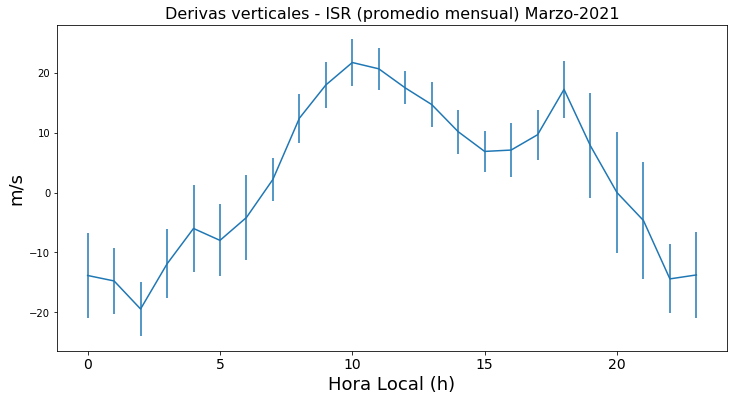

In [15]:
list_avg = []
list_std = []

series_avg = pd.concat(frames_avg)
series_std = pd.concat(frames_std)
fig, axs = plt.subplots(figsize=(12, 6))
plt.rcParams['ytick.labelsize']=16
plt.rcParams['xtick.labelsize']=16
#plt.style.use('seaborn-white')#'ggplot')#'classic')
series_avg.groupby(series_avg.index.hour).mean().plot(yerr=series_avg.groupby(series_std.index.hour).std(),rot=0,ax=axs)
fig_title = 'Derivas verticales - ISR (promedio mensual) %s' % (current_month)
axs.set_title(fig_title, fontsize=16)
#axs.set_facecolor("white")
list_avg.append(series_avg.groupby(series_avg.index.hour).mean())
list_std.append(series_avg.groupby(series_avg.index.hour).std())
#axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axs.set_xlabel('Hora Local (h)', fontsize=18)
axs.set_ylabel('m/s', fontsize=18)
#axs.set_xlim([100,400])

plt.savefig('promedio-mensual-drifts-%s.png' % current_month)

In [16]:
series_avg.groupby(series_avg.index.hour).mean()
data_datetime_obj = series_avg.index.to_pydatetime()
#print(mod_datetime_obj)
data_avg_array = series_avg.groupby(series_avg.index.hour).mean().values
print(data_avg_array)
print(series_avg.index)

[-1.38680839e+01 -1.47825550e+01 -1.94691146e+01 -1.19296447e+01
 -6.00823148e+00 -7.99768662e+00 -4.17600602e+00  2.19286343e+00
  1.24186842e+01  1.79803906e+01  2.17338298e+01  2.06812891e+01
  1.74920833e+01  1.47072135e+01  1.01711198e+01  6.87273438e+00
  7.09861979e+00  9.66035156e+00  1.72435734e+01  7.78990238e+00
 -3.83293057e-03 -4.67248887e+00 -1.44363414e+01 -1.37773785e+01]
DatetimeIndex(['2021-03-25 00:00:00', '2021-03-25 00:05:00',
               '2021-03-25 00:10:00', '2021-03-25 00:15:00',
               '2021-03-25 00:20:00', '2021-03-25 00:25:00',
               '2021-03-25 00:30:00', '2021-03-25 00:35:00',
               '2021-03-25 00:40:00', '2021-03-25 00:45:00',
               ...
               '2021-03-24 23:10:00', '2021-03-24 23:15:00',
               '2021-03-24 23:20:00', '2021-03-24 23:25:00',
               '2021-03-24 23:30:00', '2021-03-24 23:35:00',
               '2021-03-24 23:40:00', '2021-03-24 23:45:00',
               '2021-03-24 23:50:00', '20

### Promedio mensual - Modelo de Scherliess-Fejer

In [17]:
str_format = "%Y-%m-%d %H:%M:%S"
modDrifts = []
xtimes = []
for doy in doys:
    d = datetime.datetime.strptime('{} {}'.format(doy, year),'%j %Y')
    y,xt = drift_model(year,doy,longitude)
    df_v = pd.Series(y, index=xt)
    modDrifts.append(df_v)
    xtimes.append(xt)

Text(0, 0.5, 'm/s')

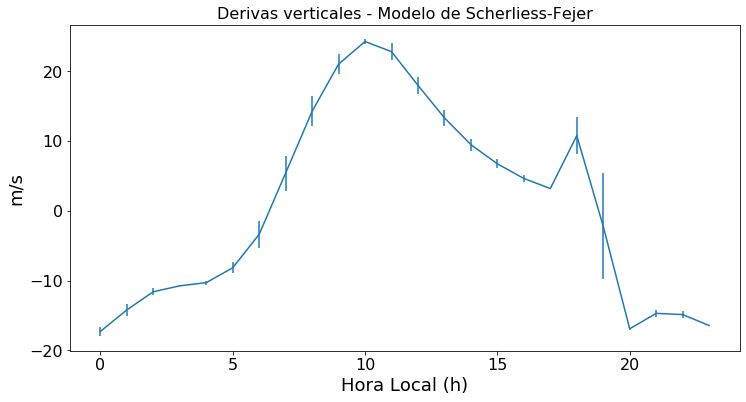

In [18]:
#'''
mod_series_avg = pd.concat(modDrifts)

list_avg.append(mod_series_avg.groupby(mod_series_avg.index.hour).mean())
list_std.append(mod_series_avg.groupby(mod_series_avg.index.hour).std())
fig, axs = plt.subplots(figsize=(12, 6))
mod_series_avg.groupby(mod_series_avg.index.hour).mean().plot(yerr=mod_series_avg.groupby(mod_series_avg.index.hour).std(),rot=0,ax=axs)
fig_title = 'Derivas verticales - Modelo de Scherliess-Fejer' 
axs.set_title(fig_title, fontsize=16)

#axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axs.set_xlabel('Hora Local (h)', fontsize=18)
axs.set_ylabel('m/s', fontsize=18)
#'''
#plt.savefig('Scherliess-Fejer-%s.png' % current_month)

In [19]:
mod_series_avg.groupby(mod_series_avg.index.hour).mean()
mod_datetime_obj = mod_series_avg.index
print(mod_datetime_obj)
mod_avg_array = mod_series_avg.groupby(mod_series_avg.index.hour).mean().values
mod_std_array = mod_series_avg.groupby(mod_series_avg.index.hour).std().values
print(mod_avg_array)

DatetimeIndex(['2021-03-22 00:00:00', '2021-03-22 00:28:00',
               '2021-03-22 00:57:00', '2021-03-22 01:26:00',
               '2021-03-22 01:55:00', '2021-03-22 02:23:00',
               '2021-03-22 02:52:00', '2021-03-22 03:21:00',
               '2021-03-22 03:50:00', '2021-03-22 04:18:00',
               ...
               '2021-03-25 18:42:00', '2021-03-25 19:11:00',
               '2021-03-25 19:39:00', '2021-03-25 20:08:00',
               '2021-03-25 20:37:00', '2021-03-25 21:06:00',
               '2021-03-25 21:34:00', '2021-03-25 22:03:00',
               '2021-03-25 22:32:00', '2021-03-25 23:01:00'],
              dtype='datetime64[ns]', length=196, freq=None)
[-17.2969745  -14.21214205 -11.61127607 -10.76657581 -10.30562687
  -8.18126583  -3.38071145   5.39584132  14.23711167  21.0057157
  24.23844343  22.78724209  17.95819885  13.29884347   9.46050433
   6.72009901   4.62097002   3.1750453   10.75906409  -2.24334327
 -16.9243844  -14.70538296 -14.88285092 -16.44

Marzo-2021


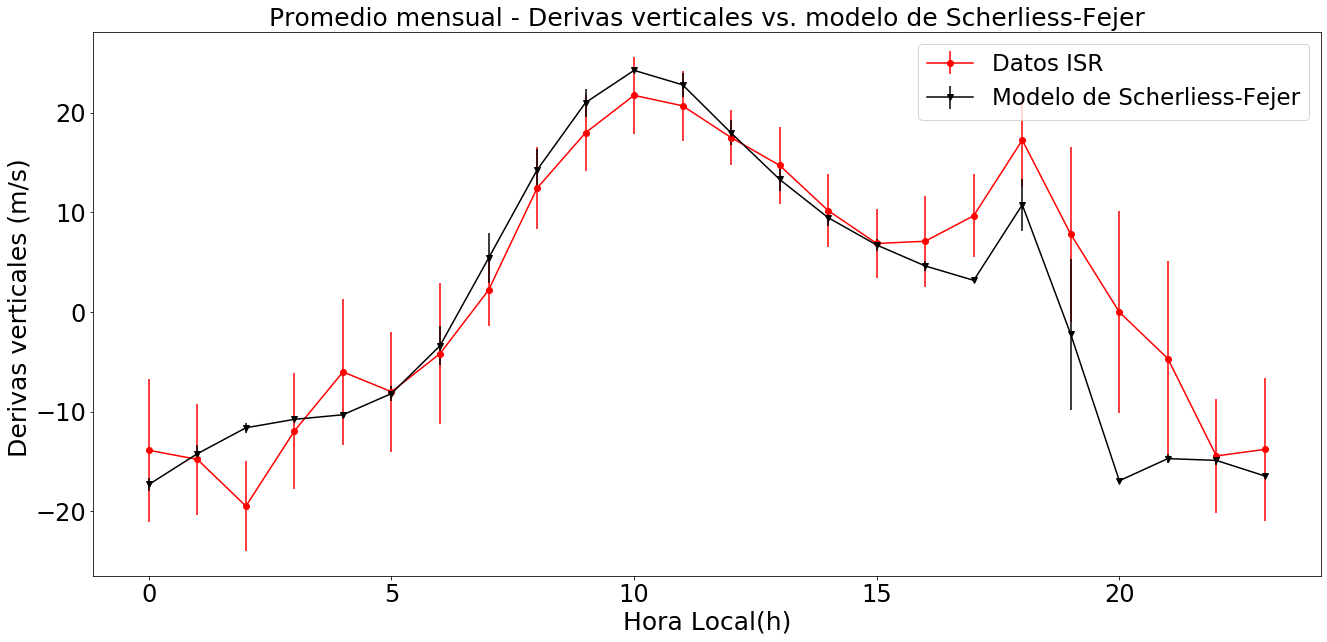

In [20]:
fig3, ax3 = plt.subplots(figsize=(22,10))
exp = ['Datos ISR', 'Modelo de Scherliess-Fejer']
markers = ['o', 'v']
plt.rcParams['ytick.labelsize']=20
plt.rcParams['xtick.labelsize']=20
colores = ['red','black']
for i in range(0,2):
    #for i in range(len(stations)):
    ax3 = list_avg[i].plot(yerr=list_std[i],label=exp[i], marker=markers[i],color=colores[i])
    ax3.set_xlabel('Hora Local(h)', fontsize=25)
    ax3.set_ylabel(r'Derivas verticales (m/s) ', fontsize=25)
    ax3.set_title('Promedio mensual - Derivas verticales vs. modelo de Scherliess-Fejer', fontsize=25)
    #plt.plot(daily_averages, color=colors[i], label=stations[i])
    ax3.tick_params(axis='y', labelsize=24)
    ax3.tick_params(axis='x', labelsize=24)
    #plt.grid(True)
#plt.xlim(6,19)
plt.legend(fontsize=23)    
print(current_month)
plt.savefig('comparison-vdrifts-data-ISR-vs-Scherliess-Fejer-%s.png' % current_month)

### Calculando RTI Promedio:

In [21]:
#year = 2020
#month = 11
#days = [24,25,26,27] 
PlotFlag = True
plot_format = 'png'
filenames = []
for dia in days:
    fname = 'jro%d%02d%02ddrifts.001.hdf5' % (year, month, dia)
    print(fname)
    filenames.append(fname)


jro20210322drifts.001.hdf5
jro20210323drifts.001.hdf5
jro20210324drifts.001.hdf5
jro20210325drifts.001.hdf5


In [22]:
def GetStandardDriftMatrix(directory,filename, plot_format):
    file_hf5 = directory + filename
    hf = h5py.File(file_hf5, 'r')
    alturas = hf['Data/Table Layout/']['gdalt']
    range_file = np.array(hf['Data/Array Layout/']['range'])
    timestamps = hf['Data/Array Layout/']['timestamps']
    vipe1 = hf['Data/Array Layout/2D Parameters/vipe1'] 
    vipn1 = hf['Data/Array Layout/2D Parameters/vipn2']
    rango2D = np.array(hf['Data/Array Layout/2D Parameters/range'])
    v_zonal = np.array(vipe1)
    v_vertical = np.array(vipn1)

    alturas = np.array(getattr(alturas, "tolist", lambda: alturas)())

    ###########################################################
    ## Arreglos del archivo:
    ran_max = np.max(rango2D)
    ran_min = np.min(rango2D)
    range_diff = np.diff(rango2D,axis=1)
    delta_range = range_diff[0][0]
    ranNum = int((ran_max-ran_min)/delta_range) + 1
    range_file = np.arange(ran_min,ran_max+delta_range,delta_range)#np.linspace(ran_min, ran_max, ranNum)
    #delta_range = range_diff[0] #valor constante para todo el arreglo
    print("ran_max: ", ran_max)
    
    datetime_objects = []
    for ts in timestamps:
        date_time_obj = datetime.datetime.fromtimestamp(ts)
        datetime_objects.append(date_time_obj)
    index = pd.DatetimeIndex(datetime_objects) #- timedelta(hours=5)
    ###Creando arreglo de datetime objetcs:
    strf = '%d-%02d-%02d 23:55:00' % (index[0].year, index[0].month, index[0].day)
    str0 = '%d-%02d-%02d 00:00:00' % (index[0].year, index[0].month, index[0].day)
    dt0 = datetime.datetime.strptime(str0, '%Y-%m-%d %H:%M:%S')
    dtf = datetime.datetime.strptime(strf, '%Y-%m-%d %H:%M:%S')
    ntimes = 288
    ncols = 100#64#96#100
    dt_list = []
    dt_array = np.arange(dt0,dtf+timedelta(seconds=300),timedelta(seconds=300))#np.array(dt_list)
    delta_time_array = np.diff(index)[0]/ np.timedelta64(1, 's')#(dtf-dt0).total_seconds()/ntimes#/np.timedelta64(1, 's')#np.linspace(dt0,dtf,timedelta(seconds=300))
    print("delta_time_array: ", delta_time_array)
    ###################################################################
    ## Arreglos Estandarizados##########################
    MinRange, MaxRange = 0,1485#945#1425#1485#945.0#1425.0#ran_min, ran_max#np.max(rango)
    DataMatrixRows = int((MaxRange-MinRange)/delta_range) + 1 #
    DataMatrix = np.ones((DataMatrixRows, ntimes))*np.nan
    RowInMatrix = np.array((rango2D[1,:]-MinRange)/delta_range, dtype=int)
    range_array = np.arange(MinRange,MaxRange+delta_range,delta_range)
    ###################################################################
    col = 0 #counter for current columns
    PastRow = 0 #saving past row index
    mes = date_time_obj.month
    month_prime = mes
    mes = GetMonth(month_prime)
    dia = date_time_obj.day
    anio = date_time_obj.year

    dir_plots = '.'#'Plots-150km-%s-%d' % (mes, anio)
    print("Shapes zonal, range 2D: ", v_zonal.T.shape, rango2D.shape)
    print("Shapes vertical, range_array, and datetime_objs: ", v_vertical.T.shape, range_file.shape, len(datetime_objects))
    print("Shapes standard: ", DataMatrix.shape, range_array.shape, dt_array.shape)
    #######################################################################################################
    print(range_array[-1])
    print(range_file[-1])
    #print(rango2D[-1])
    #print(rango[-1])
    diff = list(np.diff(rango2D).flatten())
    print(diff.count(14), diff.count(15), len(diff))
    
    datetime_objects = np.array(datetime_objects)
    RowInMatrixTime = np.array((datetime_objects-dt0)/timedelta(seconds=300),dtype=int)
    DataMat = np.ones((ntimes,ncols))*np.nan
    col = 0 #counter for current columns
    for i in range(0,datetime_objects.shape[0]):
        row = RowInMatrixTime[i]
        DataMat[row,:] = v_vertical[i,:]
    
    if (PlotFlag):
        fig, ax = plt.subplots(figsize=(12, 6))
    #plt.rcParams['xtick.labelsize']=14
        #plt.style.use('dark_background')
        clrs= ax.pcolormesh(mdates.date2num(dt_array), range_array, DataMat.T, cmap='jet')
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        fig_title = r'Derivas Verticales ISR (%d-%02d-%02d)' % (anio, month_prime, dia) 
        plt.title(fig_title, fontsize=15)
        str_date = '(%d-%02d-%02d)' % (anio, month_prime, dia)
        #ax.set_ylim(300, 1200)
        # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        box=ax.get_position()
        cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
        cb=plt.colorbar(clrs,cax=cbarax)
        cb.set_label(r'Derivas verticales (m/s)')
        plt.savefig(r'%s/Drifts-ISR-%d-%02d-%02d-v-zonal.%s' % (dir_plots,anio, month_prime, dia, plot_format))
        plt.show()
        plt.close(fig)   
    ###############################: ", DataMatrix.shape, range_file.shape, dt_array.shape)
    ####################################################################
    
    
    return DataMat.T, range_array, dt_array

ran_max:  1485.0
delta_time_array:  300.0
Shapes zonal, range 2D:  (100, 182) (182, 100)
Shapes vertical, range_array, and datetime_objs:  (100, 182) (100,) 182
Shapes standard:  (100, 288) (100,) (288,)
1485.0
1485.0
0 18018 18018


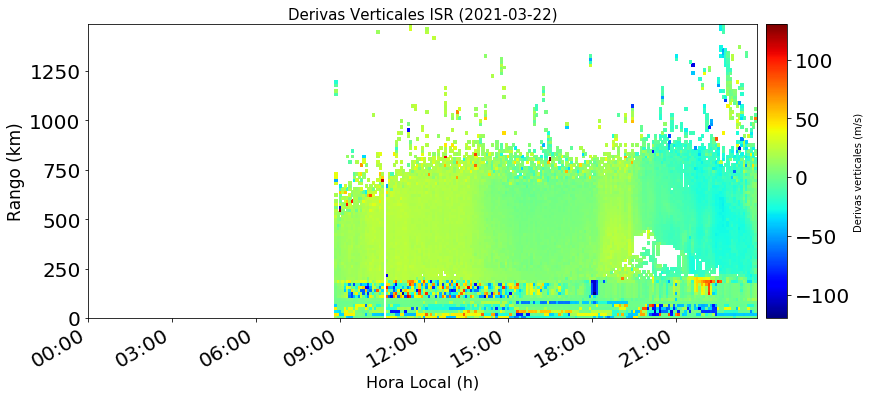

ran_max:  1485.0
delta_time_array:  300.0
Shapes zonal, range 2D:  (100, 288) (288, 100)
Shapes vertical, range_array, and datetime_objs:  (100, 288) (100,) 288
Shapes standard:  (100, 288) (100,) (288,)
1485.0
1485.0
0 28512 28512


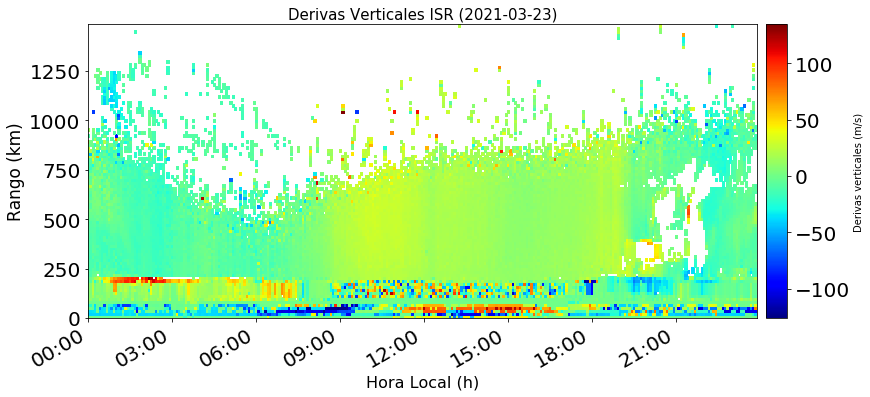

ran_max:  1485.0
delta_time_array:  300.0
Shapes zonal, range 2D:  (100, 288) (288, 100)
Shapes vertical, range_array, and datetime_objs:  (100, 288) (100,) 288
Shapes standard:  (100, 288) (100,) (288,)
1485.0
1485.0
0 28512 28512


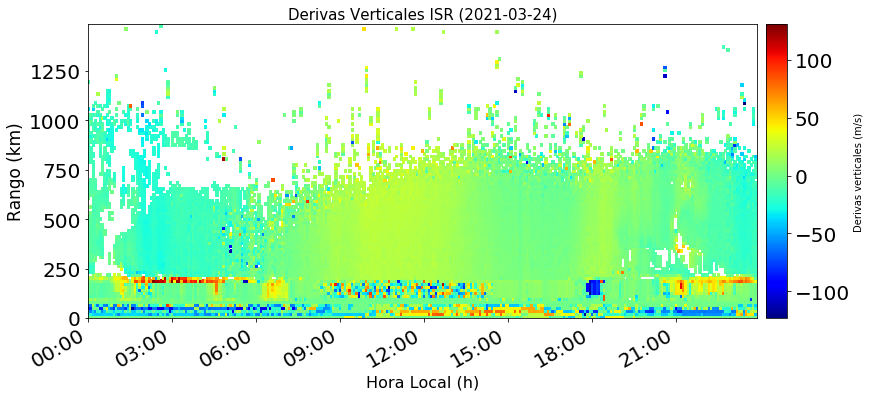

ran_max:  1485.0
delta_time_array:  300.0
Shapes zonal, range 2D:  (100, 226) (226, 100)
Shapes vertical, range_array, and datetime_objs:  (100, 226) (100,) 226
Shapes standard:  (100, 288) (100,) (288,)
1485.0
1485.0
0 22374 22374


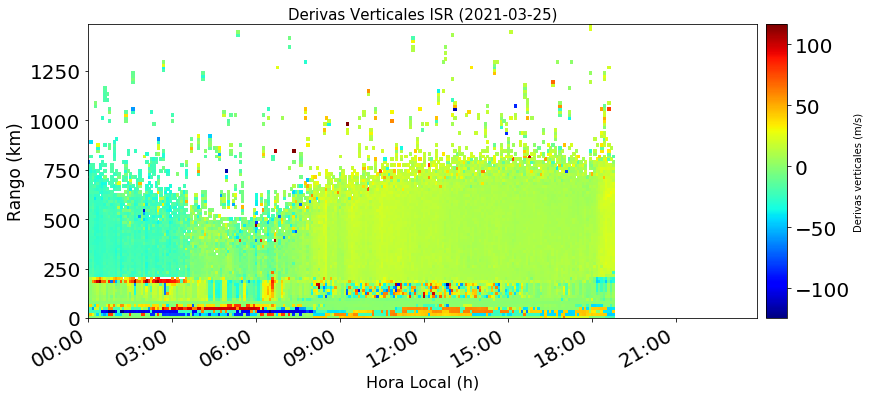

In [23]:
nfils, ncols = 100,288 #Enero-2021
#nfils, ncols = 64,288#96,288 #Noviembre-2020
#nfils, ncols = 96,288 #Noviembre-2020
auxMat = np.zeros((nfils, ncols))
numFreq = np.zeros((nfils, ncols))
for filename in filenames:
    data, range_array, dt_array = GetStandardDriftMatrix(directory,filename, plot_format)
    numFreq[np.isnan(data)==False]+=1
    data[np.isnan(data)]=0.0
    auxMat = auxMat + data
numFreq[numFreq==0] = 1
avgMat = auxMat/numFreq#/len(filenames)
#filename = 'jro%d%02d%02ddrifts.001.hdf5' % (year, d.month, 26)
#data, range_array, dt_array = GetStandardDriftMatrix(directory,filename, plot_format)

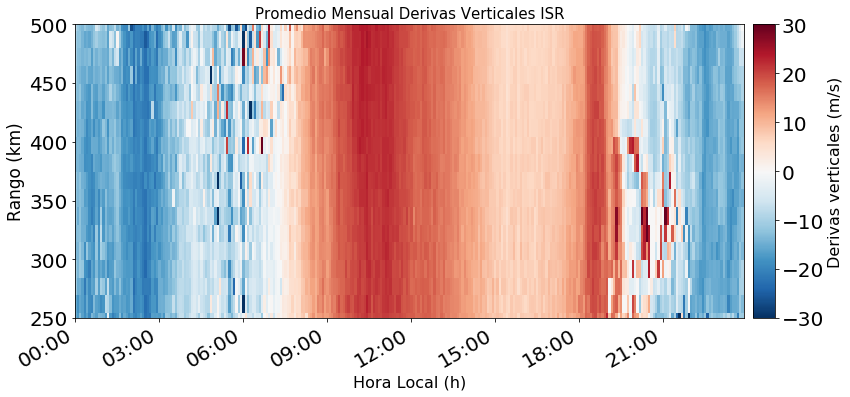

In [24]:
#avgMat[avgMat==0]=np.nan
fig, ax1 = plt.subplots(figsize=(12, 6))
    #plt.rcParams['xtick.labelsize']=14
#plt.style.use('dark_background')
clrs= ax1.pcolormesh(mdates.date2num(dt_array), range_array, avgMat, cmap=plt.cm.RdBu_r)
ax1.xaxis_date()
date_format = mdates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(date_format)
ax1.set_xlabel("Hora Local (h)", fontsize=16)
ax1.set_ylabel("Rango (km)", fontsize=17)
fig_title = r'Promedio Mensual Derivas Verticales ISR'  
plt.title(fig_title, fontsize=15)
#str_date = '(%d-%02d-%02d)' % (anio, month_prime, dia)
ax1.set_ylim(250, 500)
# This simply sets the x-axis data to diagonal so it fits better.
fig.autofmt_xdate()
box=ax1.get_position()
#cmap=plt.cm.RdBu
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)
cb.set_label(r'Derivas verticales (m/s)', fontsize=16)
#plt.clim(-30,30)
cb.mappable.set_clim(-30,30)
plt.savefig(r'data-Promedio-Mensual-Derivas-Verticales-%s.png' % current_month)

[   0.   15.   30.   45.   60.   75.   90.  105.  120.  135.  150.  165.
  180.  195.  210.  225.  240.  255.  270.  285.  300.  315.  330.  345.
  360.  375.  390.  405.  420.  435.  450.  465.  480.  495.  510.  525.
  540.  555.  570.  585.  600.  615.  630.  645.  660.  675.  690.  705.
  720.  735.  750.  765.  780.  795.  810.  825.  840.  855.  870.  885.
  900.  915.  930.  945.  960.  975.  990. 1005. 1020. 1035. 1050. 1065.
 1080. 1095. 1110. 1125. 1140. 1155. 1170. 1185. 1200. 1215. 1230. 1245.
 1260. 1275. 1290. 1305. 1320. 1335. 1350. 1365. 1380. 1395. 1410. 1425.
 1440. 1455. 1470. 1485.]
Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23],
           dtype='int64')
<class 'numpy.datetime64'>


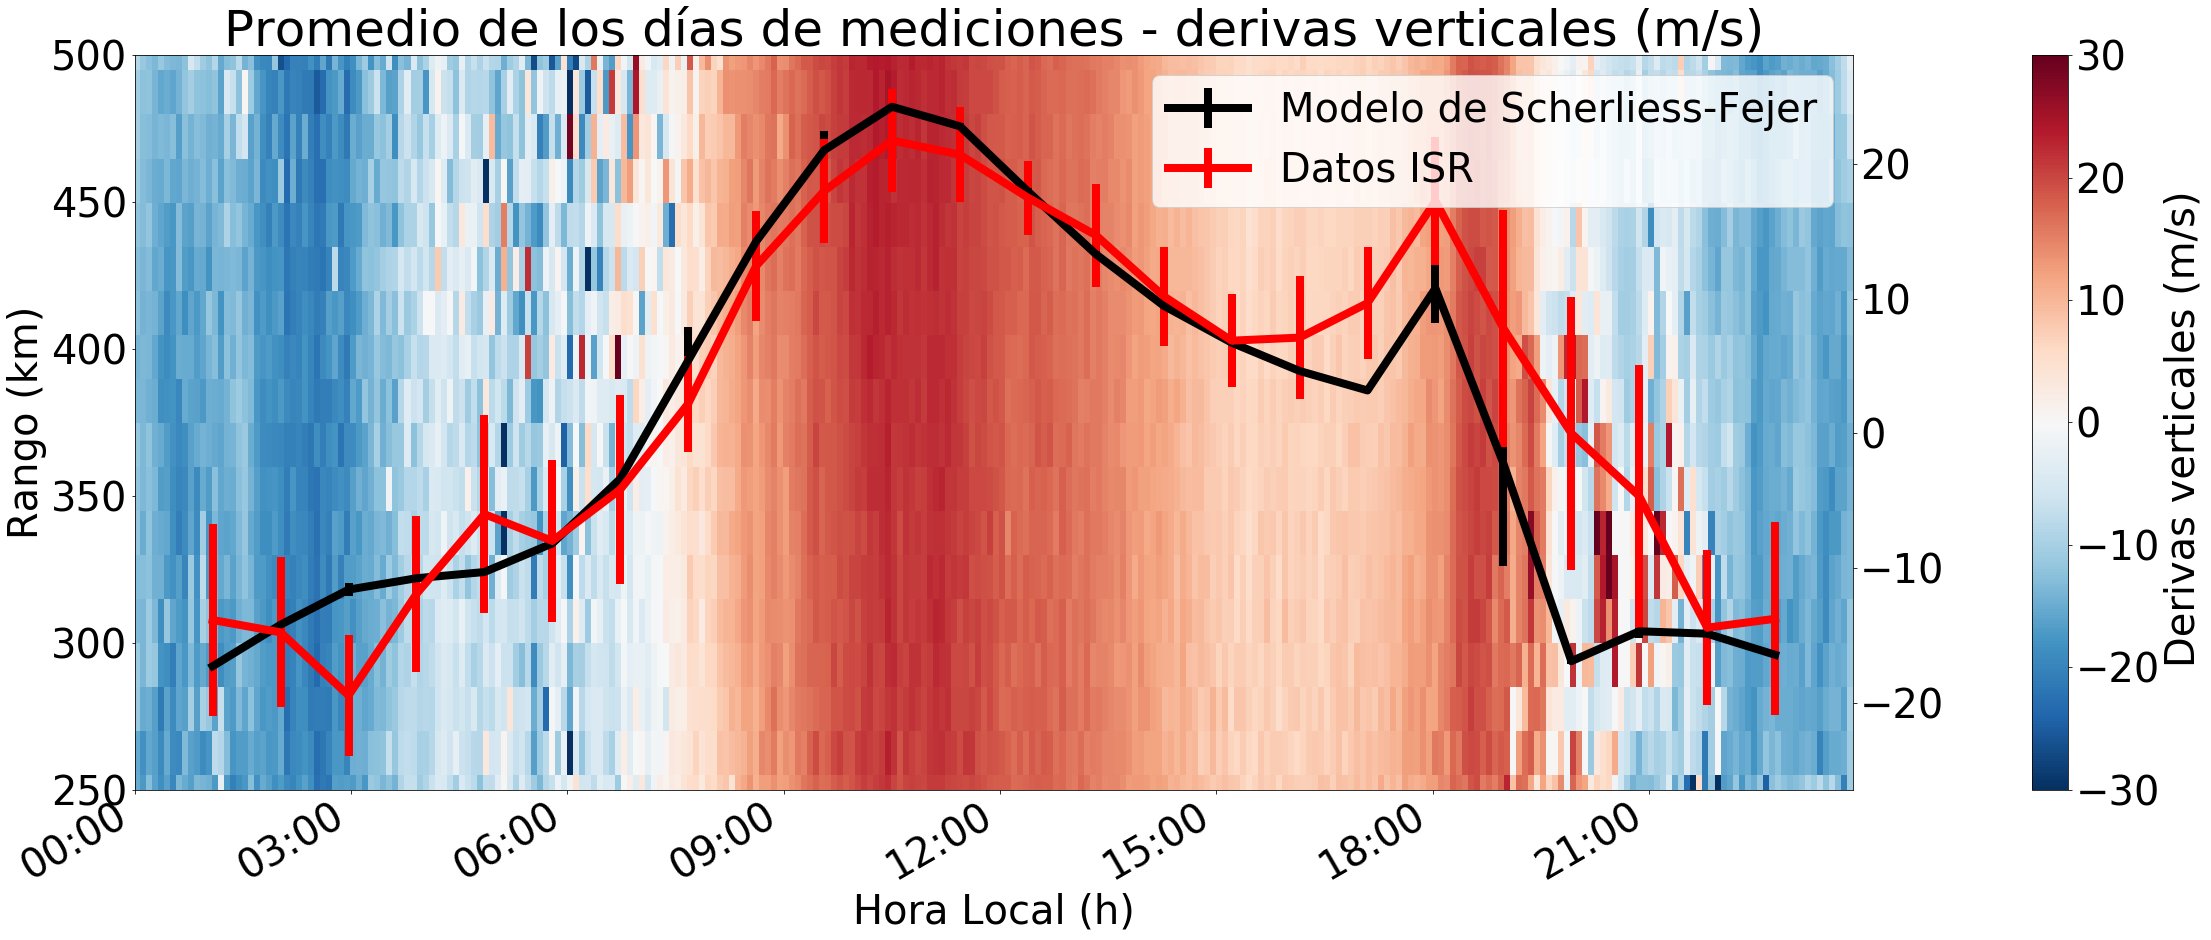

In [25]:
ind_i = 0#72
ind_f = -1#216
fig = plt.figure(figsize=(40,15))
plt.rcParams['ytick.labelsize']=40
plt.rcParams['xtick.labelsize']=40
#fig=plt.figure()
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)
plt.title("Promedio de los días de mediciones - derivas verticales (m/s)", fontsize=50)

print(range_array)
ax.plt= ax.pcolormesh(dt_array[ind_i:ind_f], range_array, avgMat[:,ind_i:ind_f], cmap=plt.cm.RdBu_r)
color='red'
#color='white'
#ax.set_xlabel('Hora Local',fontsize=22)
#ax.set_ylabel('Rango (km)',fontsize=22)
ax.set_ylim(h_min, h_max)

    ###Creando arreglo de datetime objetcs:
#strf = '%d-%02d-%02d %02d:00:00' % (index[0].year, index[0].month, index[0].day+1,0)
str0 = '%d-%02d-%02d %02d:00:00' % (index[0].year, index[0].month, index[0].day,0)
strf = '%d-%02d-%02d 23:55:00' % (index[0].year, index[0].month, index[0].day)

dt0 = datetime.datetime.strptime(str0, '%Y-%m-%d %H:%M:%S')
dtf = datetime.datetime.strptime(strf, '%Y-%m-%d %H:%M:%S')
#ax.set_xlim(8,19)
#ax.set_xlim(mdates.date2num(dt0),mdates.date2num(dtf))#dt_array[0], dt_array[-12])
ax.xaxis_date()
#date_format = mdates.DateFormatter('%H')
#ax.xaxis.set_major_formatter(date_format)
#ax.xaxis_date()
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
#minInd, maxInd = getRangeIndices(0, 10, range_array)
color_aux='white'
width_aux=6
ax.set_xlabel("Hora Local (h)", fontsize=40)
ax.set_ylabel("Rango (km)", fontsize=40)
#ax.set_xlabel("x label 1", color="C0")
#ax.set_ylabel("y label 1", color="C0")
#ax.set_ylim(130,180)
#xticks=numpy.array([0,43200,86400])
#xticks=numpy.arange(0,86400,3)
#xticks=numpy.linspace(0,86400,13,endpoint=True)
#ax.set_xticks(xticks)
#xticks_label=['00:00','02:00','04:00','06:00','08:00','10:00','12:00','14:00','16:00','18:00','20:00','22:00','24:00']
#ax.set_xticklabels(xticks_label)
#ax.set_xlim(25200,57600)
#cbar.set_label(r'$log_{10}SNR$',fontsize=30)
cbar=fig.colorbar(ax.plt,ax=ax,pad=0.08)
cbar.set_label(r'Derivas verticales (m/s) ', fontsize=40)
cbar.ax.tick_params(labelsize=40)
#plt.title(r'Ecos de 150 km (2020-11-08)',fontsize=33)
#ax.tick_params(axis='x', colors="C0")
#ax.tick_params(axis='y', colors="C0")
#cbar.remove()


d = {'24': np.nan}
ser = pd.Series(data=d, index=['24'])

list_avg_1_extended=list_avg[1].append(ser)
list_avg_0_extended=list_avg[0].append(ser)
list_std_1_extended=list_std[1].append(ser)
list_std_0_extended=list_std[0].append(ser)

#print(list_avg_extended)
#'''
list_avg[1].plot(yerr=list_std[1],label=exp[1], marker=markers[1],color='black',lw=8)
list_avg[0].plot(yerr=list_std[0],label=exp[0], marker=markers[1],color='red',lw=8)
#ax2.set_xlim(8,19)#mdates.date2num(dt0),mdates.date2num(dtf))#dt_array[0], dt_array[-12])
#ax3.set_xlim(8,19)#mdates.date2num(dt0),mdates.date2num(dtf))#dt_array[0], dt_array[-12])
#ax2.set_xlim(8,19)#mdates.date2num(dt0),mdates.date2num(dtf))#dt_array[0], dt_array[-12])
#ax3.set_xlim(8,19)#mdates.date2num(dt0),mdates.date2num(dtf))#dt_array[0], dt_array[-12])
print(list_avg[1].index)
#'''
#list_avg_1_extended.plot(yerr=list_std_1_extended,label=exp[1], marker=markers[1],color='black')
#list_avg_0_extended.plot(yerr=list_std_0_extended,label=exp[0], marker=markers[1],color='red')


fig.autofmt_xdate()

plt.legend(loc="upper right",prop={'size':40})
#ax2.xaxis.tick_top()
#nan_series={}

ax2.get_xaxis().set_visible(False)
#ax2.set_xlim(mdates.date2num(dt0),mdates.date2num(dtf))#dt_array[0], dt_array[-12])

ax2.yaxis.tick_right()
print(type(dt_array[0]))
#ax2.hlines(y=0, xmin=dt_array[0], xmax=dt_array[-1], color=color_aux, linestyle='--',linewidth=width_aux)

#ax2.set_xlabel('x label 2', color="C1") 
#ax2.set_ylabel('y label 2')#, color="C1")       
#ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
#ax2.tick_params(axis='x')#, colors="C1")
#ax2.tick_params(axis='y')#, colors="C1")
#ax2.set_xlim("2020-11-08 07:00:00","2020-11-08 16:00:00")
#ax2.set_ylabel(r'Derivas verticales (m/s) ', fontsize=26)
#ax2.set_ylim([-50,50])
#ax2.set_xlim([6,18])

cbar2=fig.colorbar(ax.plt,ax=ax2,pad=0.08)
cbar2.mappable.set_clim(-30,30)

cbar2.remove()

plt.savefig('RTI-promedio-vs-promedio-derivas-verticales-ISR-data-modelo-%s.png' % current_month)
#plt.show()
#print('dt_array:', dt_array)


In [26]:
#dt_array
dataPyDatetime = list_avg[0].index.values
#print(type(dataPyDatetime))
print(dataPyDatetime)
#print(index)
#index2 = index + timedelta(hours=0.5)
#print(index2)
dt_objs = []
for dP in dataPyDatetime:
    date_time_str = '%d-%02d-%02d %02d:00:00' % (year, month, index[0].day, dP)
    date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')
    dt_objs.append(date_time_obj)#+timedelta(minutes=30))
date_time_str2 = '%d-%02d-%02d %02d:55:00' % (year, month, index[0].day,23)
date_time_obj2 = datetime.datetime.strptime(date_time_str2, '%Y-%m-%d %H:%M:%S')

dt_objs.append(date_time_obj2)
time_objects_avg = np.array(dt_objs)

print(time_objects_avg[0],time_objects_avg[-1])
print(dt_array[0],dt_array[-1])
print(time_objects_avg)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
2021-03-24 00:00:00 2021-03-24 23:55:00
2021-03-25T00:00:00.000000 2021-03-25T23:55:00.000000
[datetime.datetime(2021, 3, 24, 0, 0) datetime.datetime(2021, 3, 24, 1, 0)
 datetime.datetime(2021, 3, 24, 2, 0) datetime.datetime(2021, 3, 24, 3, 0)
 datetime.datetime(2021, 3, 24, 4, 0) datetime.datetime(2021, 3, 24, 5, 0)
 datetime.datetime(2021, 3, 24, 6, 0) datetime.datetime(2021, 3, 24, 7, 0)
 datetime.datetime(2021, 3, 24, 8, 0) datetime.datetime(2021, 3, 24, 9, 0)
 datetime.datetime(2021, 3, 24, 10, 0)
 datetime.datetime(2021, 3, 24, 11, 0)
 datetime.datetime(2021, 3, 24, 12, 0)
 datetime.datetime(2021, 3, 24, 13, 0)
 datetime.datetime(2021, 3, 24, 14, 0)
 datetime.datetime(2021, 3, 24, 15, 0)
 datetime.datetime(2021, 3, 24, 16, 0)
 datetime.datetime(2021, 3, 24, 17, 0)
 datetime.datetime(2021, 3, 24, 18, 0)
 datetime.datetime(2021, 3, 24, 19, 0)
 datetime.datetime(2021, 3, 24, 20, 0)
 datetime.datetime(2021, 3, 

In [35]:
print(dt_array[78])
print(dt_array[222])#222])#228])#216])
ind_i = 0
ind_f = -1#222

2021-03-25T06:30:00.000000
2021-03-25T18:30:00.000000


0    -17.296974
1    -14.212142
2    -11.611276
3    -10.766576
4    -10.305627
5     -8.181266
6     -3.380711
7      5.395841
8     14.237112
9     21.005716
10    24.238443
11    22.787242
12    17.958199
13    13.298843
14     9.460504
15     6.720099
16     4.620970
17     3.175045
18    10.759064
19    -2.243343
20   -16.924384
21   -14.705383
22   -14.882851
23   -16.449430
dtype: float64
Marzo-2021


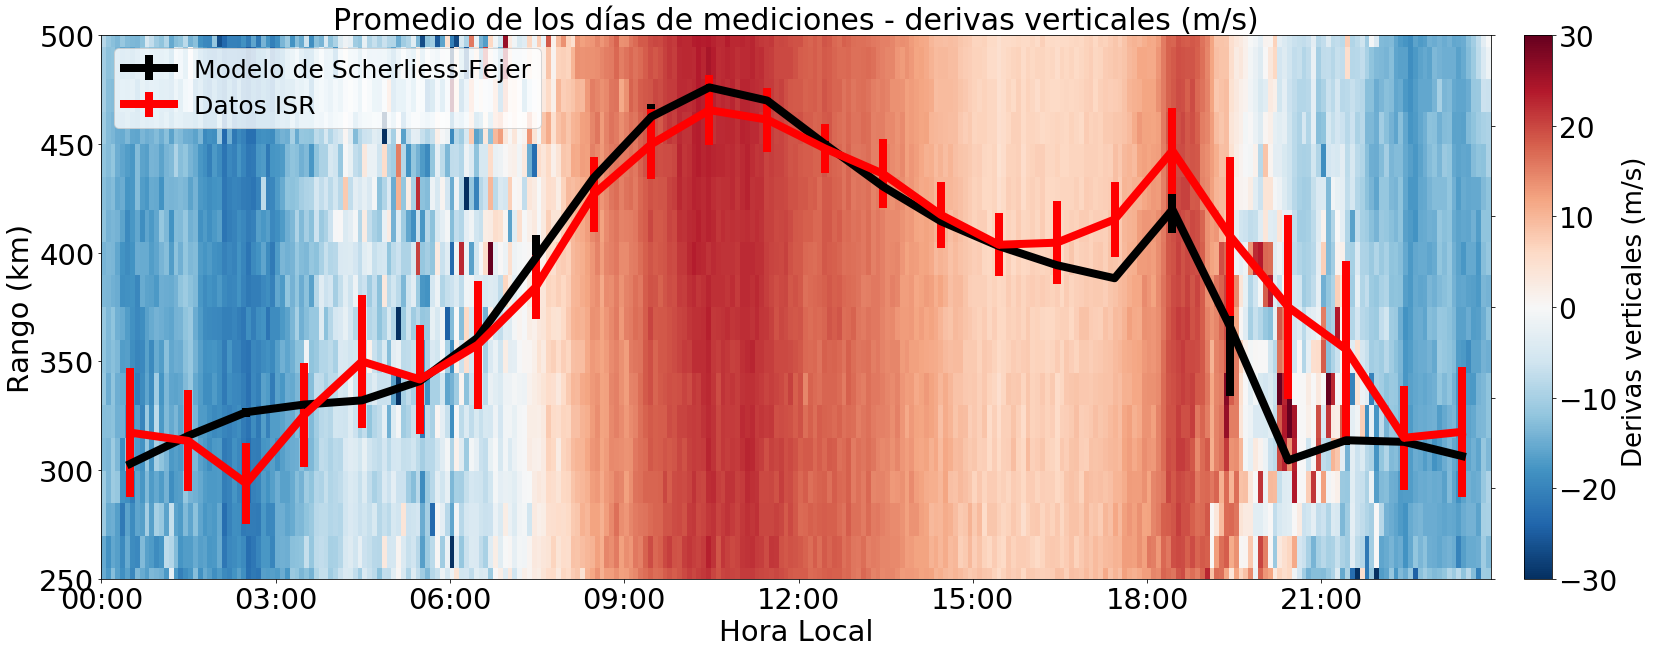

In [39]:
fig = plt.figure(figsize=(30,10))
plt.rcParams['ytick.labelsize']=29
plt.rcParams['xtick.labelsize']=29
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)
plt.title("Promedio de los días de mediciones - derivas verticales (m/s)", fontsize=30)
#plt.style.use('white')
#print(dt_array[-1])
#print(dt_array[-12])
#print(dt_array[-66:-46])
#print(np.nanmean(avgMat[20:28,-66:-46],axis=0))
#print(range_array)
ax.plt= ax.pcolormesh(dt_array, range_array, avgMat, cmap=plt.cm.RdBu_r)
#ax.plt= ax.pcolormesh(dt_array, range_array, avgMat, cmap=plt.cm.RdBu_r)

color='red'
#color='white'
ax.set_xlabel('Hora Local',fontsize=29)
ax.set_ylabel('Rango (km)',fontsize=29)
#ax.set_ylim(300, 400)
ax.set_ylim(250, 500)
#ax.set_xlim([mdates.date2num(dt_array[ind_i]),mdates.date2num(dt_array[ind_f])])

#ax.set_xlim(dt_array[0], dt_array[-12])
ax.xaxis_date()
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
color_aux='white'
width_aux=6

cbar=fig.colorbar(ax.plt,ax=ax,pad=0.02)
cbar.set_label(r'Derivas verticales (m/s) ', fontsize=26)
cbar.ax.tick_params(labelsize=28)

print(list_avg[1])
list_avg[1].plot(yerr=list_std[1],label=exp[1], marker=markers[1],color='black',lw=8)
list_avg[0].plot(yerr=list_std[0],label=exp[0], marker=markers[1],color='red',lw=8)


plt.legend(loc="upper left",prop={'size':25})
ax2.axes.yaxis.set_ticklabels([])
nan_series={}
ax2.get_xaxis().set_visible(False)
ax2.yaxis.tick_right()

ax2.set_ylim([-30,30])
ax2.set_xlim([-0.5,23.5])#7.5,19.5
#ax2.set_xlim([6,18])
cbar2=fig.colorbar(ax.plt,ax=ax2,pad=0.02)
cbar2.mappable.set_clim(-30,30)

cbar2.remove()
print(current_month)
plt.savefig('RTI-promedio-vs-promedio-derivas-verticales-ISR-data-modelo-%s.png' % current_month,dpi=500,bbox_inches="tight")
plt.show()

2021-03-25T23:55:00.000000
2021-03-25T23:00:00.000000
['2021-03-25T18:30:00.000000' '2021-03-25T18:35:00.000000'
 '2021-03-25T18:40:00.000000' '2021-03-25T18:45:00.000000'
 '2021-03-25T18:50:00.000000' '2021-03-25T18:55:00.000000'
 '2021-03-25T19:00:00.000000' '2021-03-25T19:05:00.000000'
 '2021-03-25T19:10:00.000000' '2021-03-25T19:15:00.000000'
 '2021-03-25T19:20:00.000000' '2021-03-25T19:25:00.000000'
 '2021-03-25T19:30:00.000000' '2021-03-25T19:35:00.000000'
 '2021-03-25T19:40:00.000000' '2021-03-25T19:45:00.000000'
 '2021-03-25T19:50:00.000000' '2021-03-25T19:55:00.000000'
 '2021-03-25T20:00:00.000000' '2021-03-25T20:05:00.000000']
[20.44625    19.9978125  19.9140625  19.6384375  18.37625    17.84875
 15.16083333 11.92375    14.34916667 15.91125    19.861875   13.97229167
 10.18625     2.53       -1.735625   -2.72125     0.084375    0.3125
  1.933125    0.56      ]
[   0.   15.   30.   45.   60.   75.   90.  105.  120.  135.  150.  165.
  180.  195.  210.  225.  240.  255.  270.  

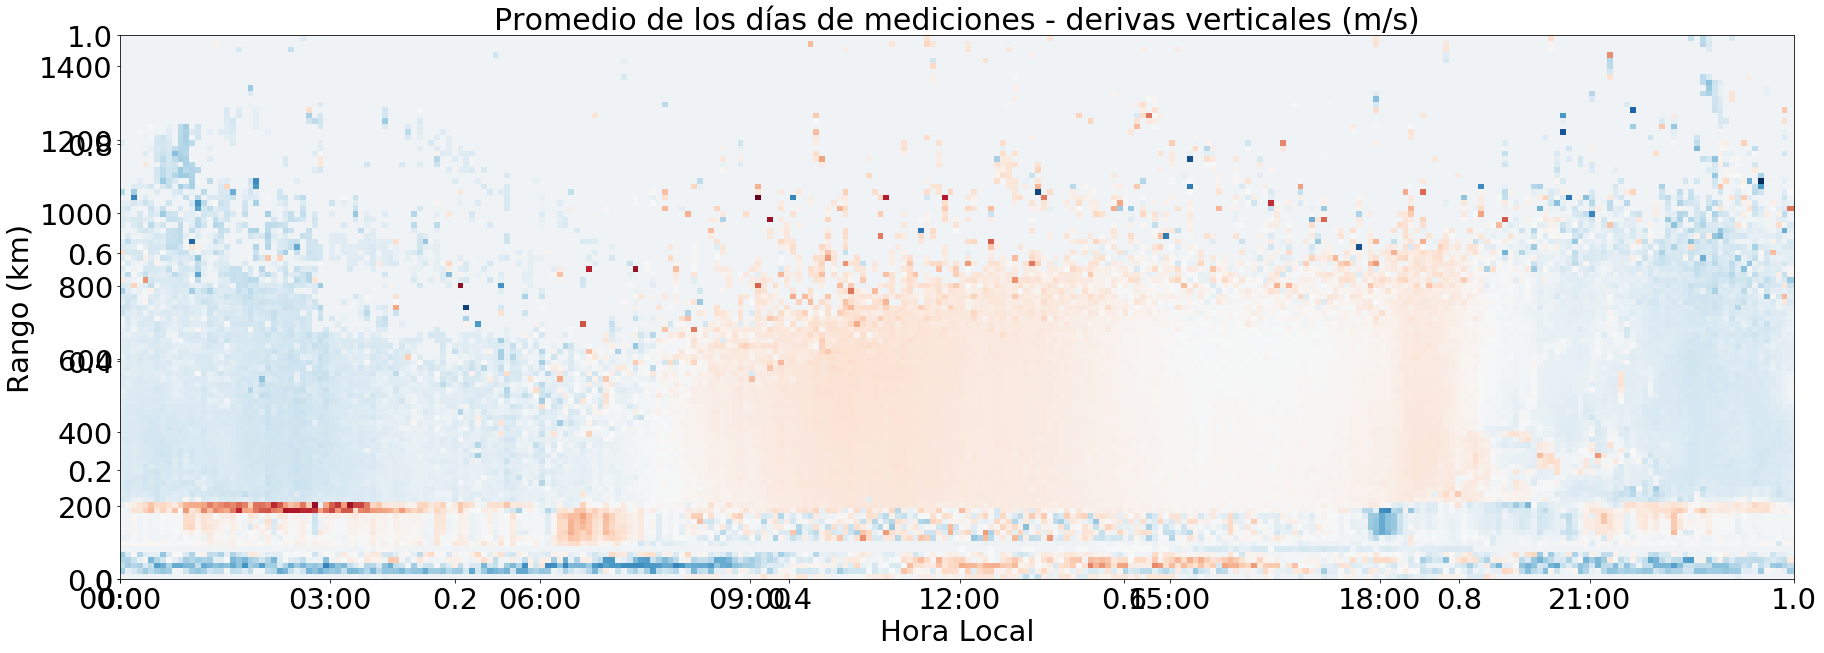

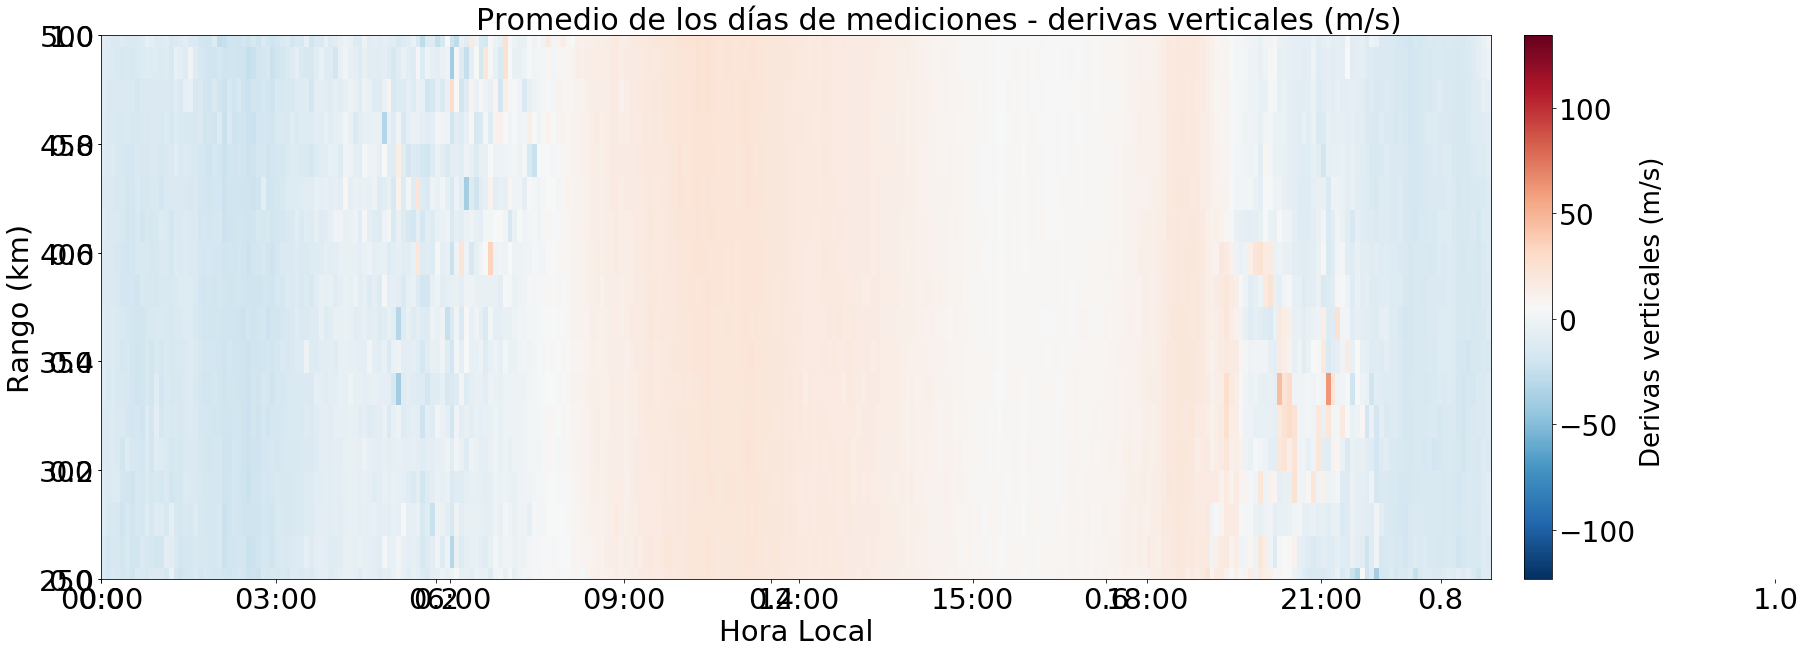

2021-03-25T23:55:00.000000
2021-03-25T23:00:00.000000
['2021-03-25T18:30:00.000000' '2021-03-25T18:35:00.000000'
 '2021-03-25T18:40:00.000000' '2021-03-25T18:45:00.000000'
 '2021-03-25T18:50:00.000000' '2021-03-25T18:55:00.000000'
 '2021-03-25T19:00:00.000000' '2021-03-25T19:05:00.000000'
 '2021-03-25T19:10:00.000000' '2021-03-25T19:15:00.000000'
 '2021-03-25T19:20:00.000000' '2021-03-25T19:25:00.000000'
 '2021-03-25T19:30:00.000000' '2021-03-25T19:35:00.000000'
 '2021-03-25T19:40:00.000000' '2021-03-25T19:45:00.000000'
 '2021-03-25T19:50:00.000000' '2021-03-25T19:55:00.000000'
 '2021-03-25T20:00:00.000000' '2021-03-25T20:05:00.000000']
[20.44625    19.9978125  19.9140625  19.6384375  18.37625    17.84875
 15.16083333 11.92375    14.34916667 15.91125    19.861875   13.97229167
 10.18625     2.53       -1.735625   -2.72125     0.084375    0.3125
  1.933125    0.56      ]
[   0.   15.   30.   45.   60.   75.   90.  105.  120.  135.  150.  165.
  180.  195.  210.  225.  240.  255.  270.  

'\nlist_avg_1_extended=list_avg[1].insert(loc=0,column="A",value=ser)\nlist_avg_0_extended=list_avg[0].insert(0,ser)\nlist_std_1_extended=list_std[1].insert(0,ser)\nlist_std_0_extended=list_std[0].insert(0,ser)\n'

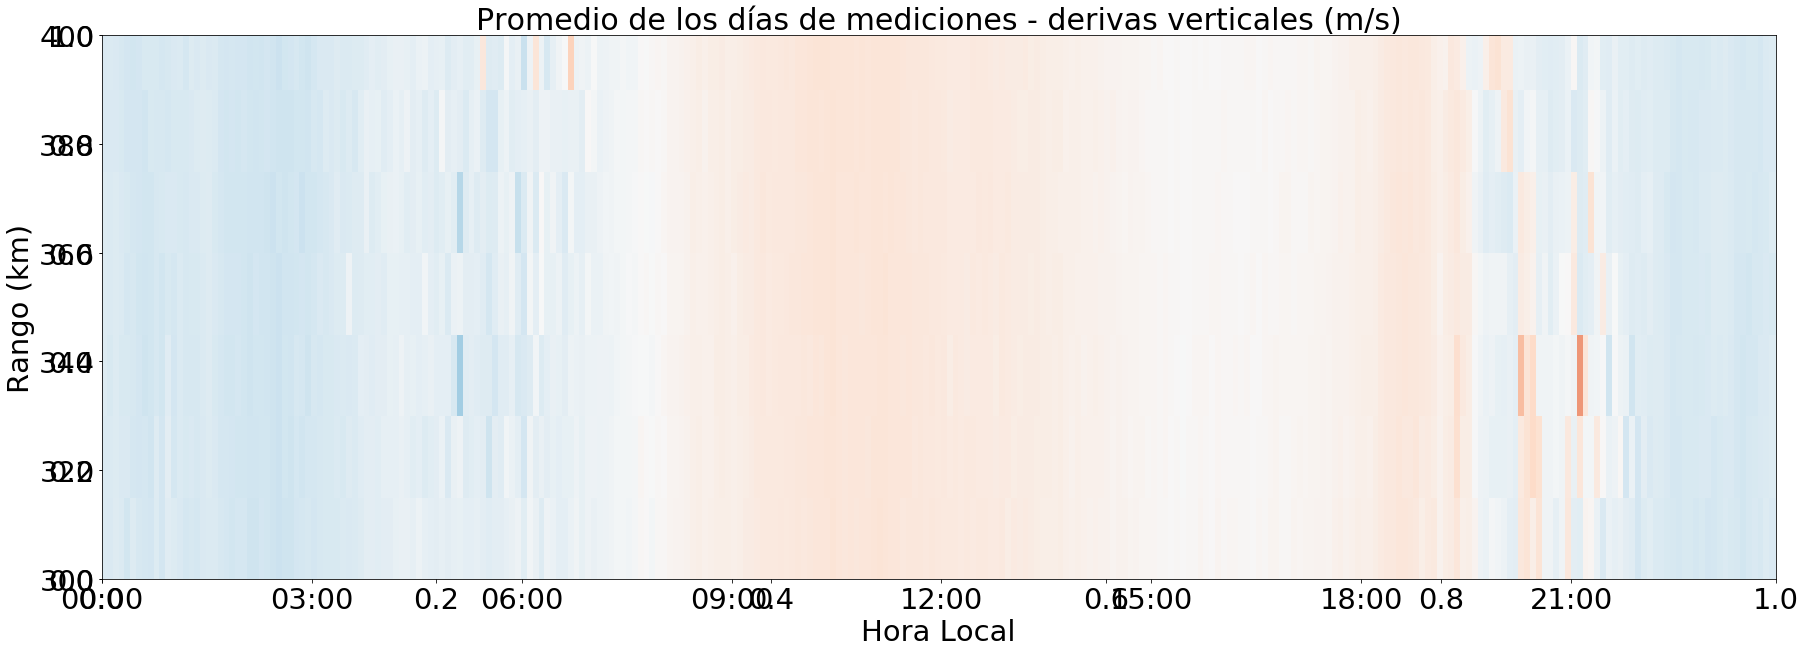

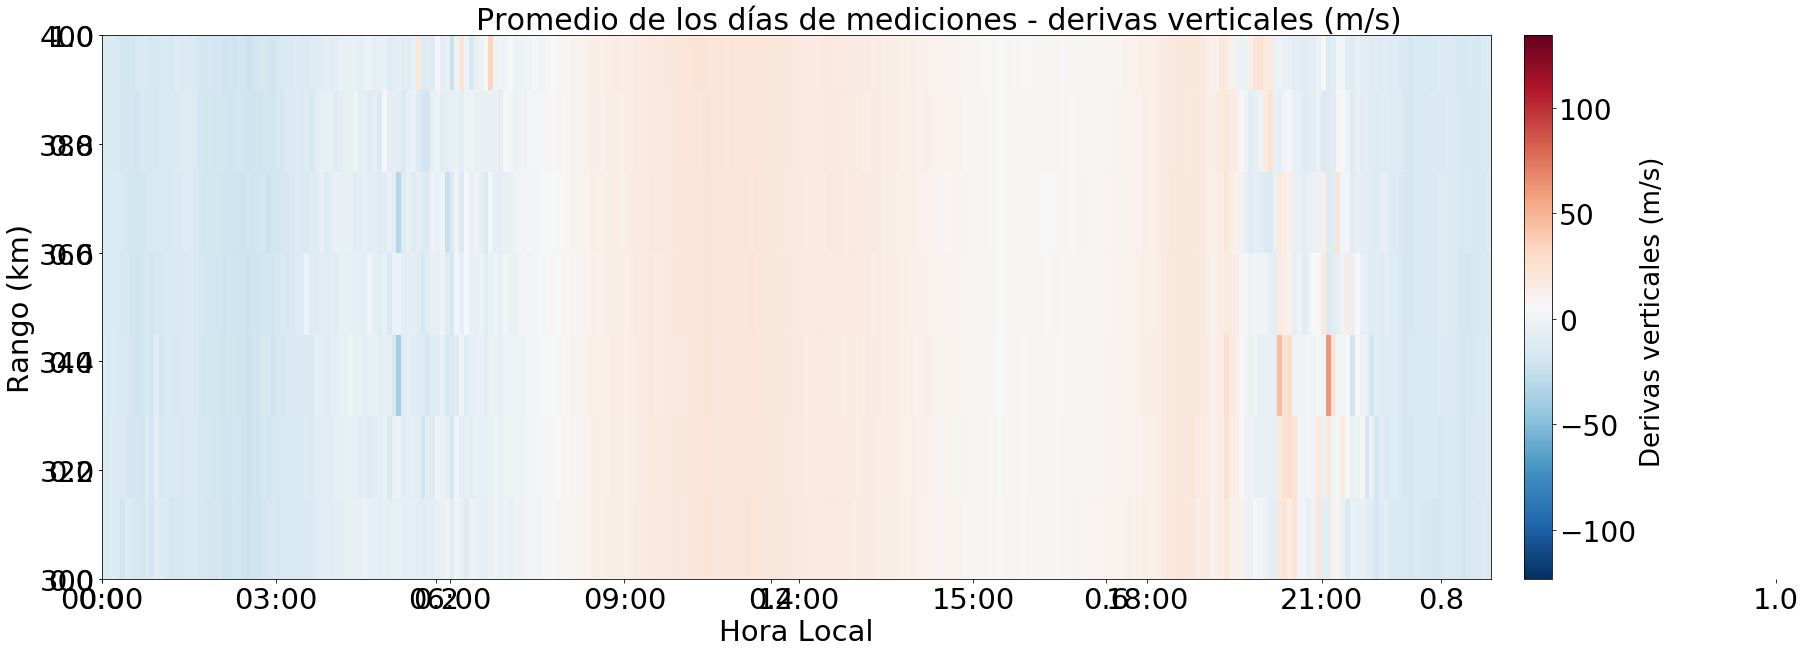

In [33]:
fig = plt.figure(figsize=(30,10))
plt.rcParams['ytick.labelsize']=29
plt.rcParams['xtick.labelsize']=29
#fig=plt.figure()
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)
plt.title("Promedio de los días de mediciones - derivas verticales (m/s)", fontsize=30)
#plt.style.use('white')

ax.plt= ax.pcolormesh(dt_array, range_array, avgMat, cmap=plt.cm.RdBu_r)
color='red'
#color='white'
ax.set_xlabel('Hora Local',fontsize=29)
ax.set_ylabel('Rango (km)',fontsize=29)
ax.set_ylim(300, 400)
ax.xaxis_date()
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
#minInd, maxInd = getRangeIndices(0, 10, range_array)
color_aux='white'
width_aux=6

#ax.set_xlabel("x label 1", color="C0")
#ax.set_ylabel("y…
fig = plt.figure(figsize=(30,10))
plt.rcParams['ytick.labelsize']=29
plt.rcParams['xtick.labelsize']=29
#fig=plt.figure()
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)
plt.title("Promedio de los días de mediciones - derivas verticales (m/s)", fontsize=30)
#plt.style.use('white')
print(dt_array[-1])
print(dt_array[-12])
print(dt_array[-66:-46])
#print(np.shape(dt_array))
#print(np.shape(avgMat))
print(np.nanmean(avgMat[20:28,-66:-46],axis=0))
print(range_array)
ax.plt= ax.pcolormesh(dt_array, range_array, avgMat, cmap=plt.cm.RdBu_r)
color='red'
#color='white'
ax.set_xlabel('Hora Local',fontsize=29)
ax.set_ylabel('Rango (km)',fontsize=29)
ax.set_ylim(300, 400)
#ax.set_xlim(dt_array[0], dt_array[-12])
ax.xaxis_date()
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
#minInd, maxInd = getRangeIndices(0, 10, range_array)
color_aux='white'
width_aux=6

#ax.set_xlabel("x label 1", color="C0")
#ax.set_ylabel("y label 1", color="C0")
#ax.set_ylim(130,180)
#xticks=numpy.array([0,43200,86400])
#xticks=numpy.arange(0,86400,3)
#xticks=numpy.linspace(0,86400,13,endpoint=True)
#ax.set_xticks(xticks)
#xticks_label=['00:00','02:00','04:00','06:00','08:00','10:00','12:00','14:00','16:00','18:00','20:00','22:00','24:00']
#ax.set_xticklabels(xticks_label)
#ax.set_xlim(25200,57600)
#cbar.set_label(r'$log_{10}SNR$',fontsize=30)
cbar=fig.colorbar(ax.plt,ax=ax,pad=0.02)
#cbar=fig.colorbar(ax.plt,ax=ax)
cbar.set_label(r'Derivas verticales (m/s) ', fontsize=26)
cbar.ax.tick_params(labelsize=28)
#plt.title(r'Ecos de 150 km (2020-11-08)',fontsize=33)
#ax.tick_params(axis='x', colors="C0")
#ax.tick_params(axis='y', colors="C0")
#cbar.remove()


'''
listAVG0=list_avg[0]
listAVG1=list_avg[1]
listSTD0=list_std[0]
listSTD1=list_std[1]

for i in range(49):
    if i==0:
        d = {i: np.nan}
        listAVG0_data = pd.Series(data=d, index=[i])
        listAVG1_data = pd.Series(data=d, index=[i])
        listSTD0_data = pd.Series(data=d, index=[i])
        listSTD1_data = pd.Series(data=d, index=[i])
        #print("0",i,ser)
        
    else:
        if i%2==0:
            d = {i: np.nan}
            ser1 = pd.Series(data=d, index=[i])
            ser=ser.append(ser1)
            listAVG0_data = listAVG0_data.append(ser1)
            listAVG1_data = listAVG1_data.append(ser1)
            listSTD0_data = listSTD0_data.append(ser1)
            listSTD1_data = listSTD1_data.append(ser1)
            
            #print("impar",i,ser1)
            #print("SS",d,i,ser)
            #print(ser)
        else:
            d2_avg0 = {i: listAVG0[int(i/2)]}
            d2_avg1 = {i: listAVG1[int(i/2)]}
            d2_std0 = {i: listSTD0[int(i/2)]}
            d2_std1 = {i: listSTD1[int(i/2)]}
            #print("d2",d2)
            #print(d2)
            ser2 = pd.Series(data=d2_avg0, index=[i])
            listAVG0_data=listAVG0_data.append(ser2)
            ser2 = pd.Series(data=d2_avg1, index=[i])
            listAVG1_data=listAVG1_data.append(ser2)
            ser2 = pd.Series(data=d2_std0, index=[i])
            listSTD0_data=listSTD0_data.append(ser2)
            ser2 = pd.Series(data=d2_std1, index=[i])
            listSTD1_data=listSTD1_data.append(ser2)
            #print("par",i,ser2)
        #print(ser)
  
print("before")
#print("ser",ser)
print("after")
'''
#xraycolor='tab:blue'
#ax2.plot(xrs_a_series.loc["2020-11-08T 07:00:00":"2020-11-08T 16:00:00"],linestyle='-', color=xraycolor,linewidth=4,label='Flujo de Rayos X')
#ax2 = list_avg[1].plot(yerr=list_std[1],label=exp[1], marker=markers[1])
'''
print(list_avg[0])
print(list_avg[0].append(ser))
print(list_avg[1])
'''
aux=list_avg[1]
#print("aux",aux[0])

'''
list_avg_1_extended=list_avg[1].insert(loc=0,column="A",value=ser)
list_avg_0_extended=list_avg[0].insert(0,ser)
list_std_1_extended=list_std[1].insert(0,ser)
list_std_0_extended=list_std[0].insert(0,ser)
'''


/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


Text(0.5, 35.2, 'Hora Local')

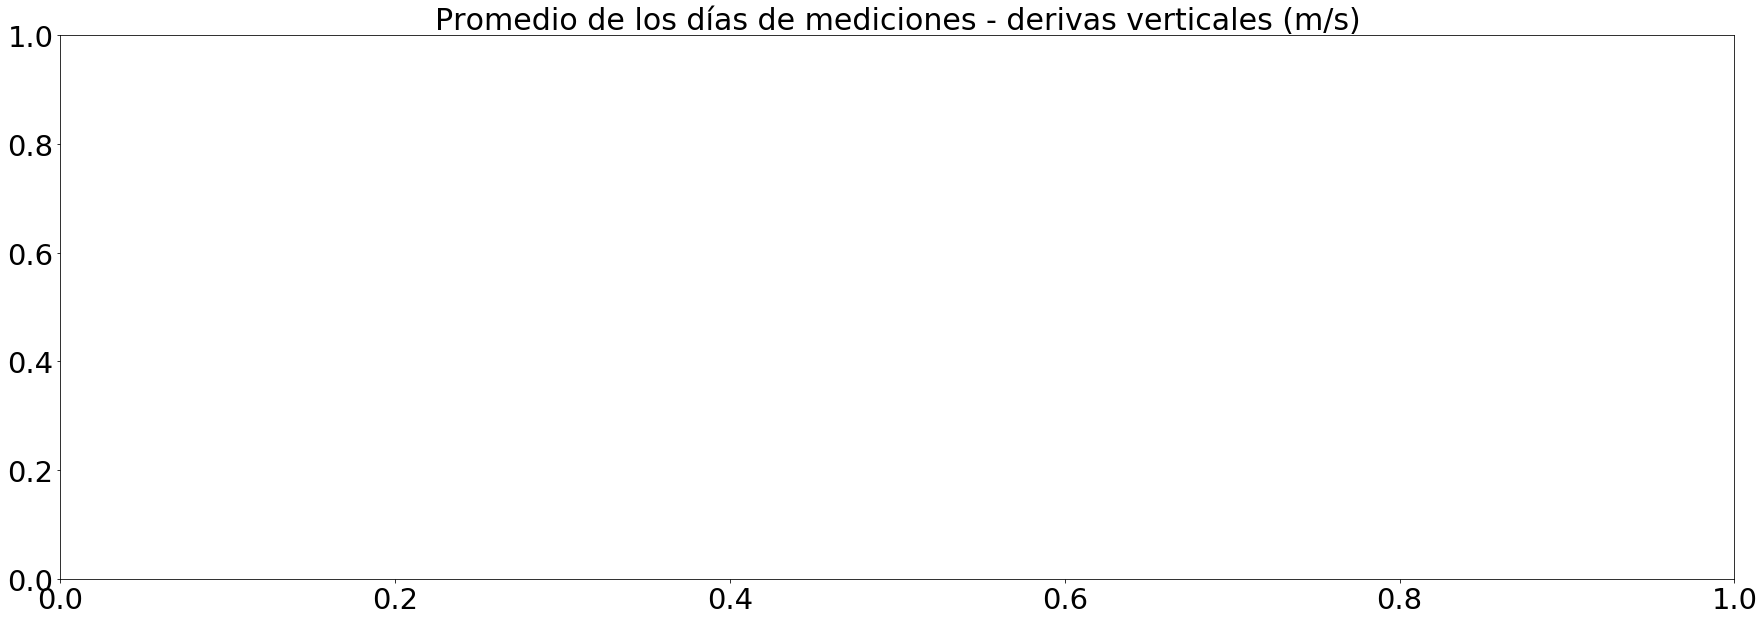

In [34]:
Roberto: fig = plt.figure(figsize=(30,10))
plt.rcParams['ytick.labelsize']=29
plt.rcParams['xtick.labelsize']=29
#fig=plt.figure()
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)
plt.title("Promedio de los días de mediciones - derivas verticales (m/s)", fontsize=30)
#plt.style.use('white')

ax.plt= ax.pcolormesh(dt_array, range_array, avgMat, cmap=plt.cm.RdBu_r)
color='red'
#color='white'
ax.set_xlabel('Hora Local',fontsize=29)